# Personal Information
Name: **Miguel Vella**

StudentID: **15403750**

Email: [**miguel.vella@student.uva.nl**](youremail@student.uva.nl)

Submitted on: **23.03.2025**

# Data Context

The data that will be used for this thesis is associated with sensor data and room occupancy. Thus, three data sets will be used:
- **LAB42 Sensor Data:** Data provided from sensors per room in LAB42 containing readings for Air Quality (CO2ppm), Light (lumen), Daylight (lumen), and Temperature (ºC). There are over 5000 different sensors distrubted over seven floors. For the purposes of this thesis, sensor readings from lecture rooms will be used, which are present in the first 3 floors.
- **LAB42 Lecture Room Schedule:** A schedule for hourly intervals of lecture room allocation in LAB42, indicating if a lecture is scheduled to take place. This dataset will be used in conjunction with the LAB42 sensor data to serve as an indication for when a room should be occupied. Due to potential misalignments with real occupancy (e.g. lecture cancellations), this dataset will be supplemented with manual occupancy checks in the building.
- **UCI Occupancy Dataset:** A public dataset that contains 20650 sensor readings from an office room including CO2 (ppm), Light (lux), Temperature (ºC), and occupancy state (binary). This data is publically available, and thus will be used to pre-train and evaluate the model before using the LAB42 Sensor Data. This dataset is available via: https://archive.ics.uci.edu/dataset/357/occupancy+detection

# Data Description


Since I am working with two datasets for sensor readings, this EDA will be split up in two sub-sections, a sub-section for the LAB42 dataset and a sub-section for the UCI dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from influxdb_client import InfluxDBClient
import missingno as msno
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

## EDA on LAB42 Sensor Data

### Data Loading

Data was previously loaded using InfluxDB - no longer required as data is accessible via .csv

In [6]:
# Influx DB connection details.
# influxdb_url = ""
# influxdb_token = ""
# influxdb_org = ""
# influxdb_bucket = ""

# Connect to InfluxDB
# client = InfluxDBClient(url=influxdb_url, token=influxdb_token, org=influxdb_org, timeout=3_600_000)
# query_api = client.query_api()

In [5]:
# Query data from InfluxDB for October, November, January and February
# query = f'''
# from(bucket: "{influxdb_bucket}")
#   |> range(start: 2024-10-01T00:00:00Z, stop: 2025-02-28T23:59:59Z)
#   |> filter(fn: (r) => r._measurement == "room_data")
#   |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
#   |> keep(columns: ["_time", "room_number", "temperature", "airquality", "daylight", "light", "lecture_scheduled", "room_id", "capacity"])
# '''
#
# # Execute the query and convert to dataframe
# full_df = query_api.query_data_frame(query)
#
# # Convert timestamp to datetime
# full_df['_time'] = pd.to_datetime(full_df['_time'])
#
# # Get number of rows and columns
# print(f"Number of rows: {full_df.shape[0]}")

In [4]:
full_df = pd.read_csv("../lab42_sensor_data.csv")

# Convert timestamp to datetime
full_df['_time'] = pd.to_datetime(full_df['_time'])

# Get number of rows and columns
print(f"Number of rows: {full_df.shape[0]}")

Number of rows: 3036245


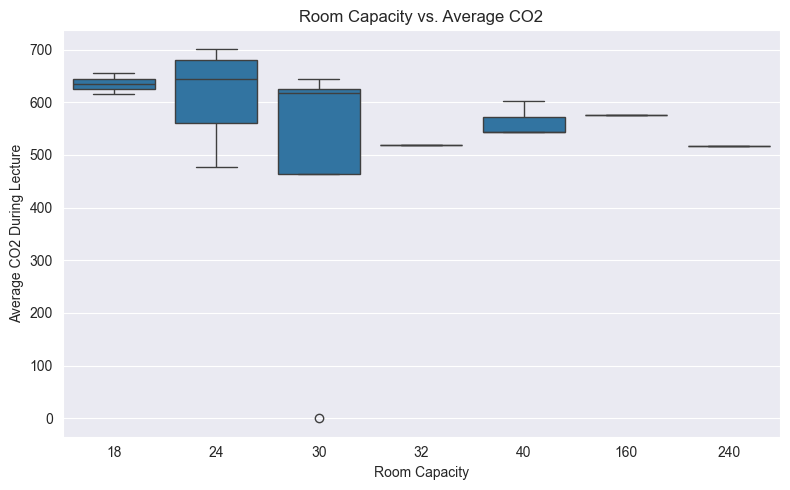

In [7]:
copy = full_df.copy()

capacity_mapping = {
    "Room_01": 32,
    "Room_02": 40,
    "Room_03": 40,
    "Room_04": 40,
    "Room_05": 24,
    "Room_06": 160,
    "Room_07": 240,
    "Room_08": 24,
    "Room_09": 30,
    "Room_10": 30,
    "Room_11": 18,
    "Room_12": 18,
    "Room_13": 24,
    "Room_14": 24,
    "Room_15": 24,
    "Room_16": 30,
    "Room_17": 30,
    "Room_18": 24
}

# Compute average CO2 during lectures per room
lecture_df = copy[copy['Occupancy'] == True]
avg_co2_by_room = lecture_df.groupby('room_number')['airquality'].mean().reset_index()
avg_co2_by_room['capacity'] = avg_co2_by_room['room_number'].map(capacity_mapping)

# Create boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(x='capacity', y='airquality', data=avg_co2_by_room)
plt.xlabel('Room Capacity')
plt.ylabel('Average CO2 During Lecture')
plt.title('Room Capacity vs. Average CO2')
plt.tight_layout()
plt.savefig("capacity_vs_co2.png", dpi=300)
plt.show()


### Basic EDA

#### Check for Class Balance


The percentage of lectures scheduled vs. not scheduled for all lectures will be checked in this step. Due to the large imbalance, it might be worth excluding night hours from the dataset (e.g. 9PM-9AM)

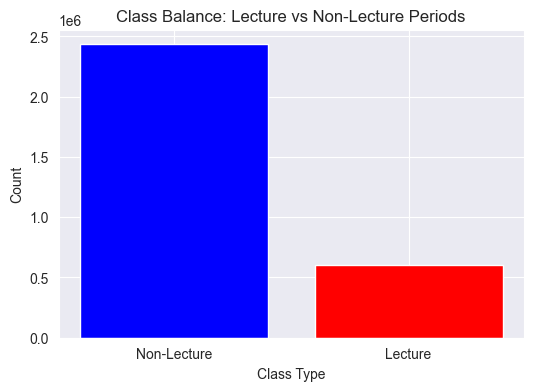

Lecture: 602579 (19.85%)
Non-Lecture: 2433666 (80.15%)


In [8]:
# Count occurrences of lecture vs non-lecture periods
lecture_counts = full_df["Occupancy"].value_counts()

# Plot class balance
plt.figure(figsize=(6, 4))
plt.bar(["Non-Lecture", "Lecture"], lecture_counts, color=["blue", "red"])
plt.title("Class Balance: Lecture vs Non-Lecture Periods")
plt.xlabel("Class Type")
plt.ylabel("Count")
plt.show()

# Print proportions
print(f"Lecture: {lecture_counts.iloc[1]} ({(lecture_counts.iloc[1] / lecture_counts.sum()) * 100:.2f}%)")
print(f"Non-Lecture: {lecture_counts.iloc[0]} ({(lecture_counts.iloc[0] / lecture_counts.sum()) * 100:.2f}%)")

#### Check for Missing Values

As can be seen in the below diagram, it seems there is some overlap in the missing sensor readings. These could be due to some sort of power outage or sensor malfunctions. Due to the relatively small number of missing sensor readings, the missing rows can be dropped from the dataset

airquality     27820
daylight       50989
light          33174
temperature    36207
dtype: int64


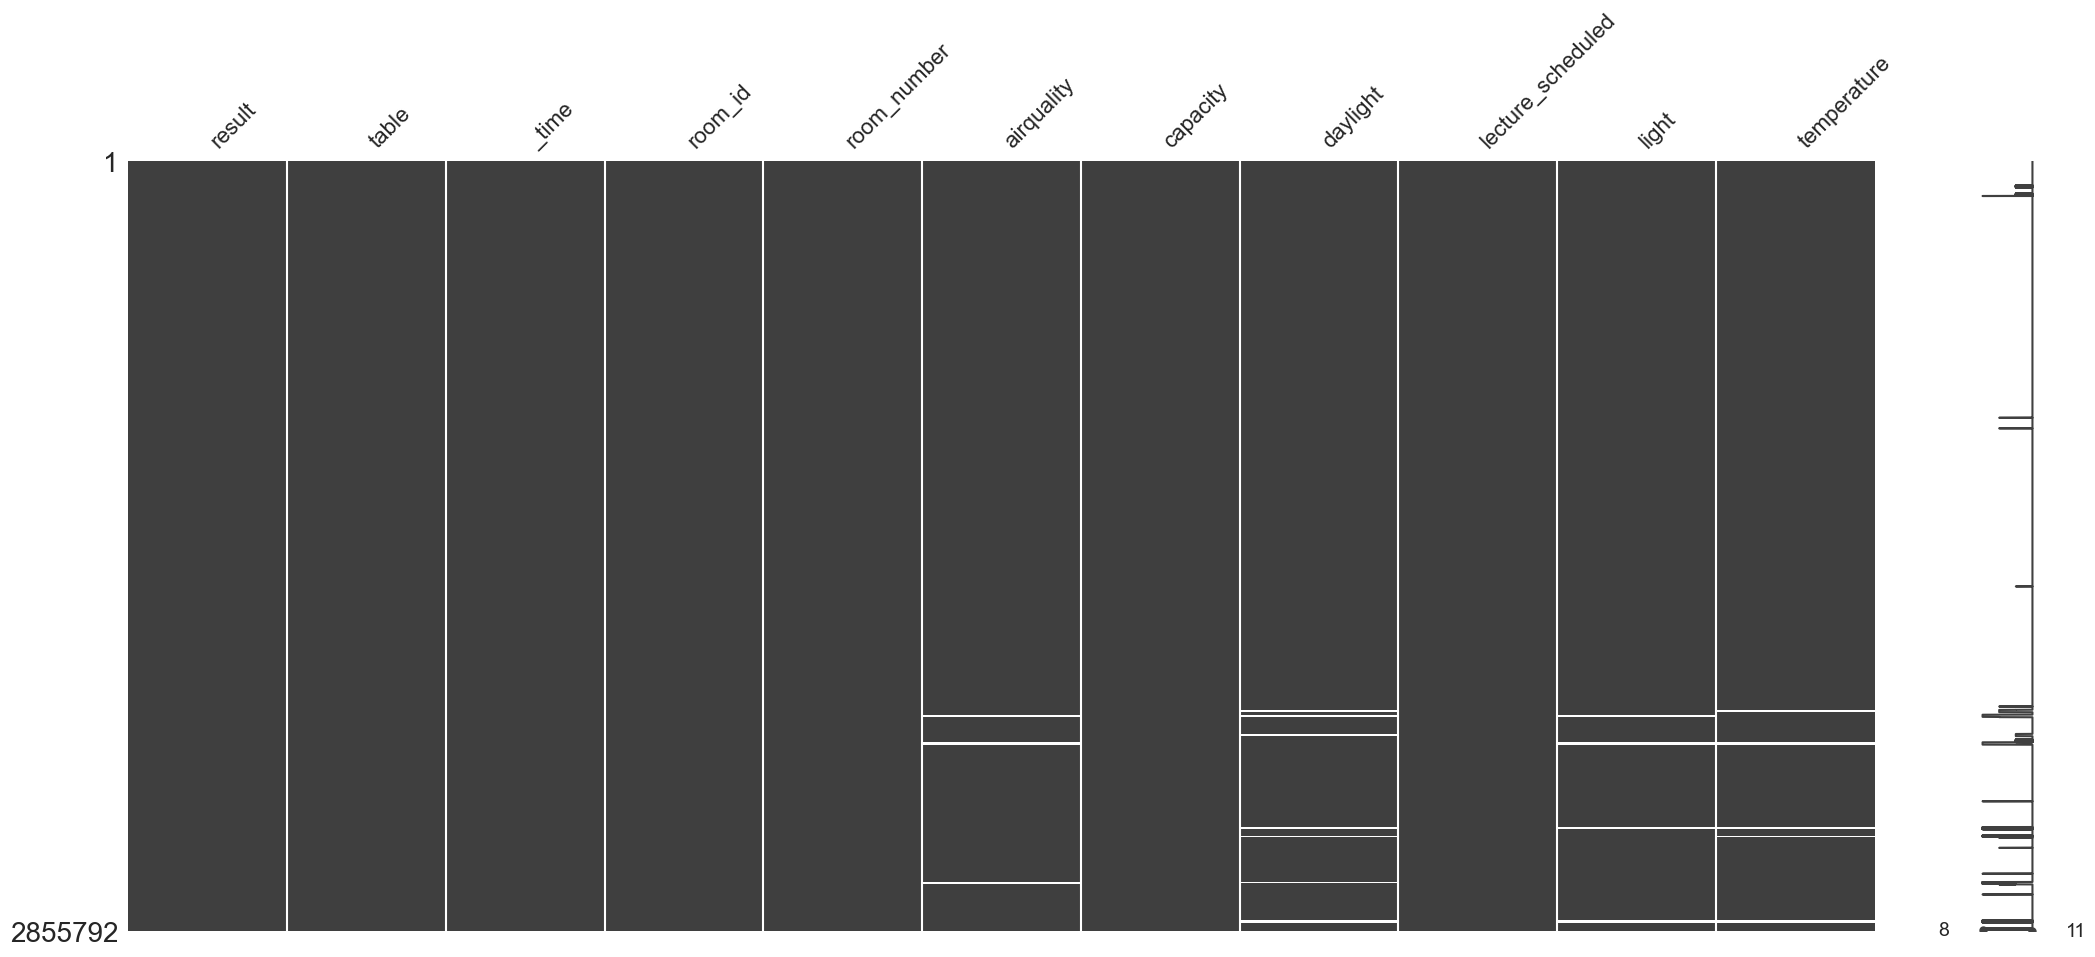

In [9]:
# Check for missing values
missing_values = full_df.isnull().sum()
print(missing_values[missing_values > 0])  # Only show columns with missing values
msno.matrix(full_df)

# Drop missing rows
full_df.dropna(inplace=True)

#### Check for Sensor Distributions

What can be understood from the sensor distributions
- **Temperature:** Seems to be mostly stable, which indicated effective climate control in the building
- **CO2 Levels:** Right skewed with a peak around 500 ppm. Some rooms seem to show poorer ventilation with levels reaching up to 1000 ppm
- **Light And Daylight:** Most rooms seem to be either dark or brightly lit. This indicates that the light sensors seem to only be useful as a check if lights are on or off

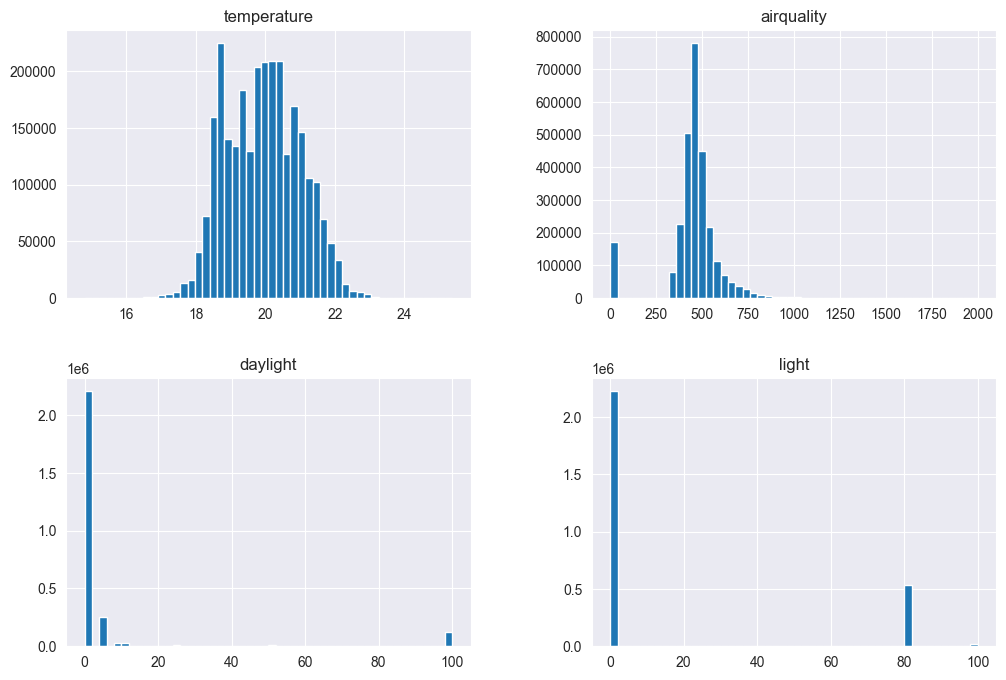

In [8]:
# Sensor distributions
sensor_columns = ["temperature", "airquality", "daylight", "light"]
full_df[sensor_columns].hist(figsize=(12, 8), bins=50)
plt.show()

#### Check for Outliers

Outliers are checked here, first looking at outliers from all the rooms and comparing outliers from all rooms. The below can be understood from the two diagrams in this section
- **CO2 Levels:** Most rooms have similar median CO2 levels, with some showing high spikes which can be attributed to occupancy fluctuations
- **Light Levels:** Some rooms consistently have high light levels while others remain low. This could be down to differences in window or sensor location.
- **Temperature:** Seems to be range between 19-22 ºC with some variations. Higher temperatures could be due to HVAC settings or usage patterns
- **Daylight:** Many rooms have near zero daylight, suggesting limited natural light exposure, probably due to sensor/window placement
- **Room Capacity:** No clear trend between room size and sensor values

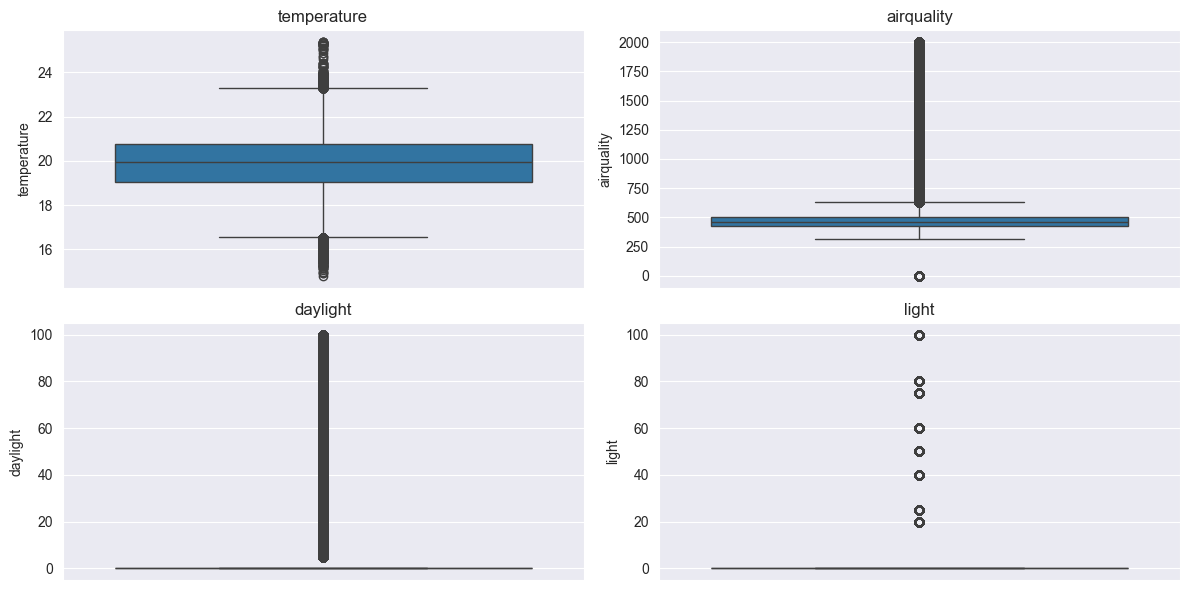

In [9]:
# Looking for any outliers
plt.figure(figsize=(12, 6))
for i, col in enumerate(sensor_columns, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(y=full_df[col])
    plt.title(col)
plt.tight_layout()
plt.show()

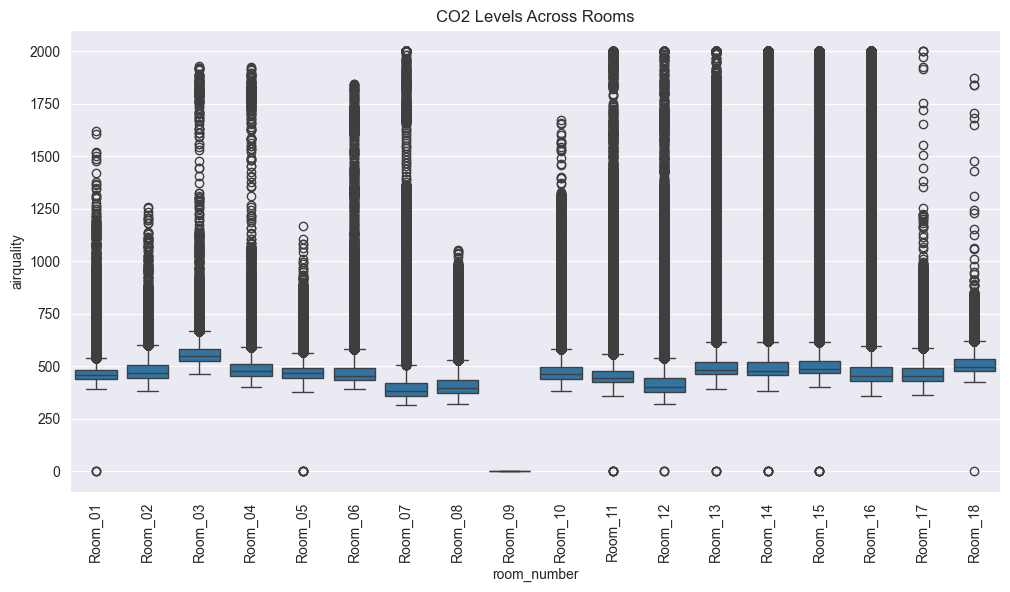

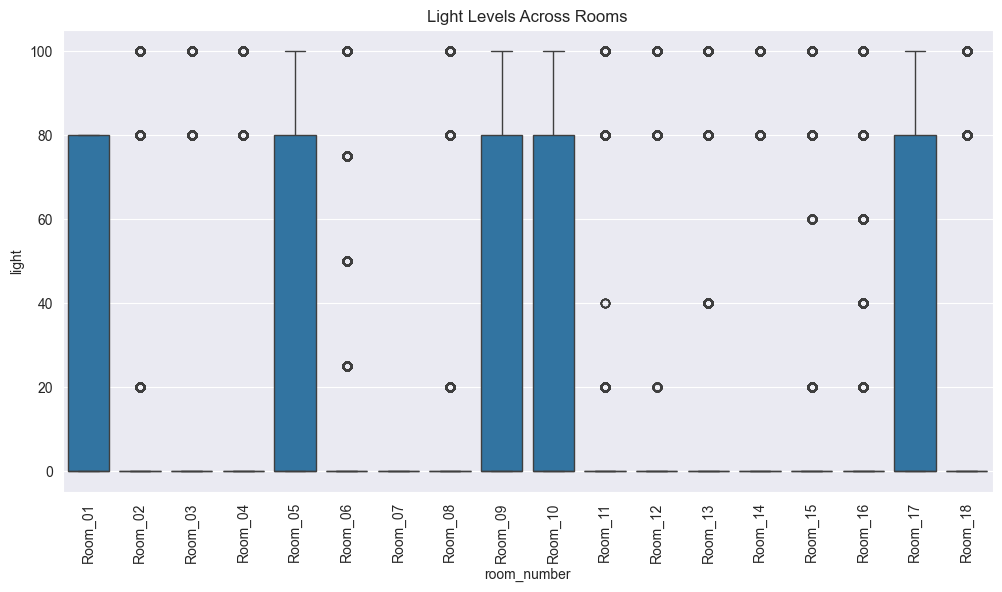

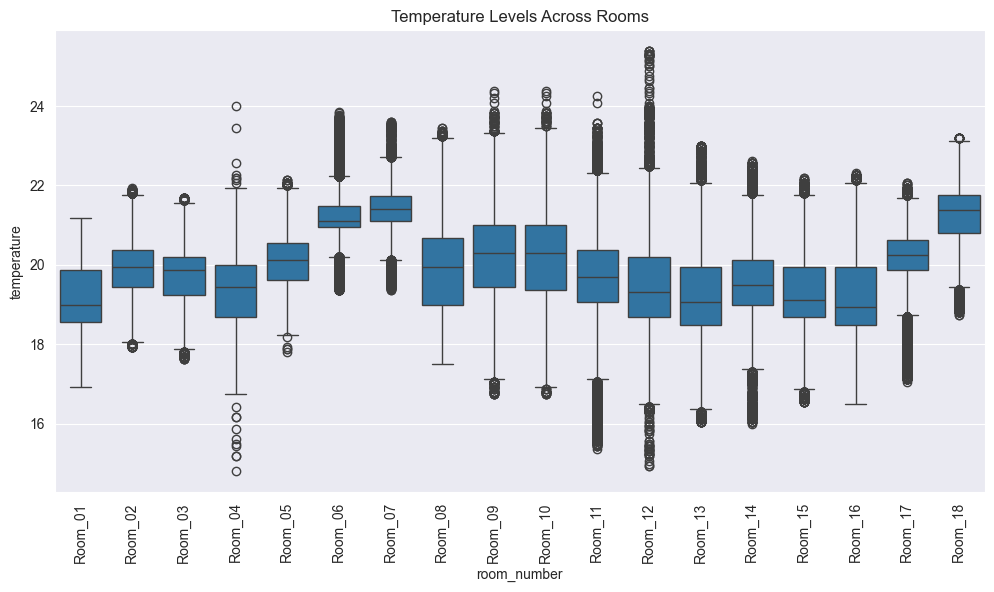

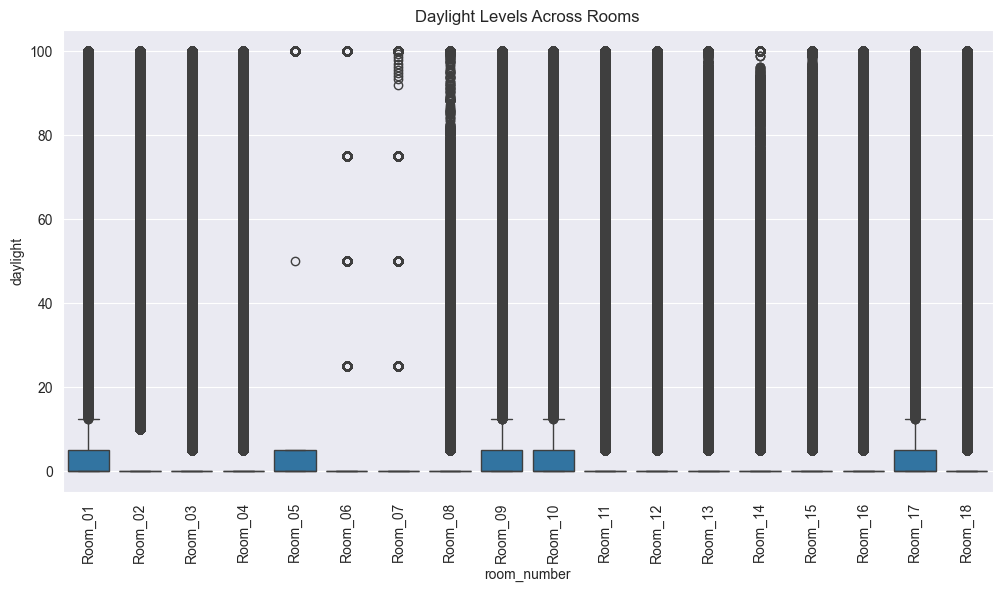

In [9]:
## Room level comparisons
# Plot for air quality
plt.figure(figsize=(12, 6))
sns.boxplot(data=full_df, x="room_number", y="airquality")
plt.xticks(rotation=90)
plt.title("CO2 Levels Across Rooms")
plt.show()

# Plot for light
plt.figure(figsize=(12, 6))
sns.boxplot(data=full_df, x="room_number", y="light")
plt.xticks(rotation=90)
plt.title("Light Levels Across Rooms")
plt.show()

# Plot for temperature
plt.figure(figsize=(12, 6))
sns.boxplot(data=full_df, x="room_number", y="temperature")
plt.xticks(rotation=90)
plt.title("Temperature Levels Across Rooms")
plt.show()

# Plot for daylight
plt.figure(figsize=(12, 6))
sns.boxplot(data=full_df, x="room_number", y="daylight")
plt.xticks(rotation=90)
plt.title("Daylight Levels Across Rooms")
plt.show()

### Temporal Analysis

In [10]:
# Extract sensor data for analysis
full_df_sensors = full_df.select_dtypes(include=["number"])

# Convert numerical columns explicitly
sensor_columns = ["temperature", "airquality", "daylight", "light"]
for col in sensor_columns:
    full_df_sensors[col] = pd.to_numeric(full_df_sensors[col], errors='coerce')

#### Hourly Trends

Two diagrams can be seen below, with the first diagram showing hourly trends over the all the months (with december missing) and the second diagram showing hourly trends for February.
- **Temperature:** Shows periodic fluctuations, with noticeable seasonal shifts
- **CO2 Levels:** Spikes seem to occur at specific times, which indicate occupancy-driven variations
- **Light:** A structured pattern seems to be in place, which can reflect scheduled room usage
- **Daylight:** Variations in seasonality with lower levels in winter months

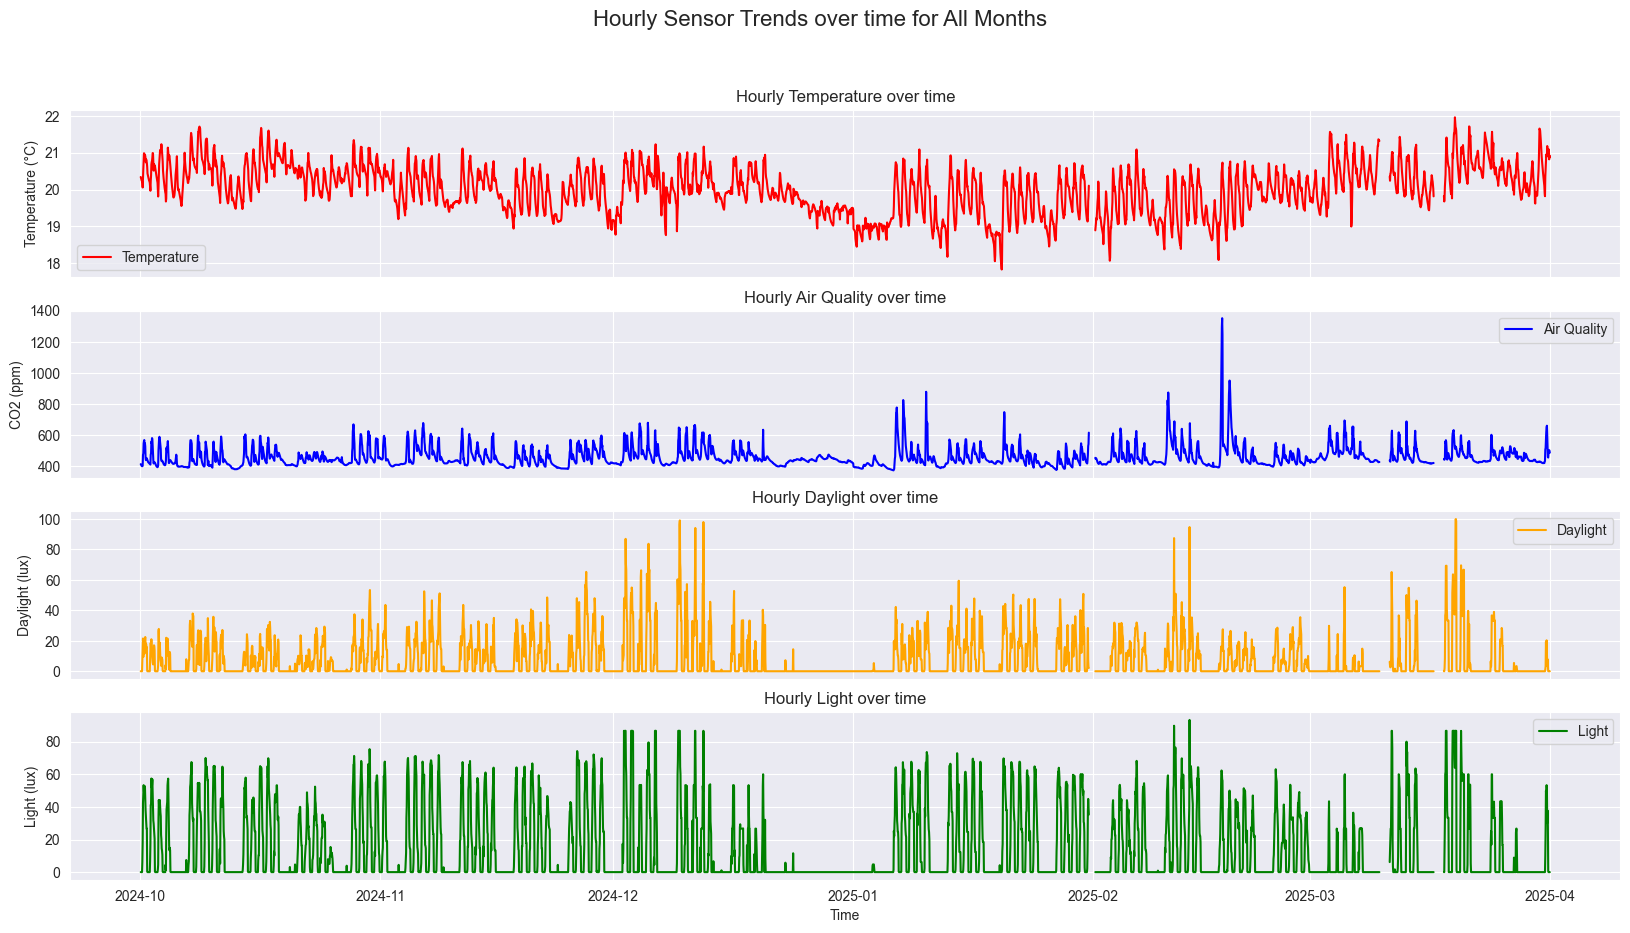

In [11]:
copy = full_df.copy()
copy.set_index('_time', inplace=True)

# Resample data to hourly frequency
full_df_hourly = copy[sensor_columns].resample('h').mean()

# Plot sensor trends over time
fig, axes = plt.subplots(4, 1, figsize=(20, 10), sharex=True)

# Set title for the figure
fig.suptitle('Hourly Sensor Trends over time for All Months', fontsize=16)
axes[3].set_xlabel('Time')

# Temperature over time
axes[0].plot(full_df_hourly.index, full_df_hourly['temperature'], label='Temperature', color='red')
axes[0].set_title('Hourly Temperature over time')
axes[0].set_ylabel('Temperature (°C)')
axes[0].legend()

# Air Quality over time
axes[1].plot(full_df_hourly.index, full_df_hourly['airquality'], label='Air Quality', color='blue')
axes[1].set_title('Hourly Air Quality over time')
axes[1].set_ylabel('CO2 (ppm)')
axes[1].legend()

# Daylight over time
axes[2].plot(full_df_hourly.index, full_df_hourly['daylight'], label='Daylight', color='orange')
axes[2].set_title('Hourly Daylight over time')
axes[2].set_ylabel('Daylight (lux)')
axes[2].legend()

# Light over time
axes[3].plot(full_df_hourly.index, full_df_hourly['light'], label='Light', color='green')
axes[3].set_title('Hourly Light over time')
axes[3].set_ylabel('Light (lux)')
axes[3].legend()

plt.show()

#### Daily Sensor Trends

All sensor readings provide similar shapes during hours of expected occupancy

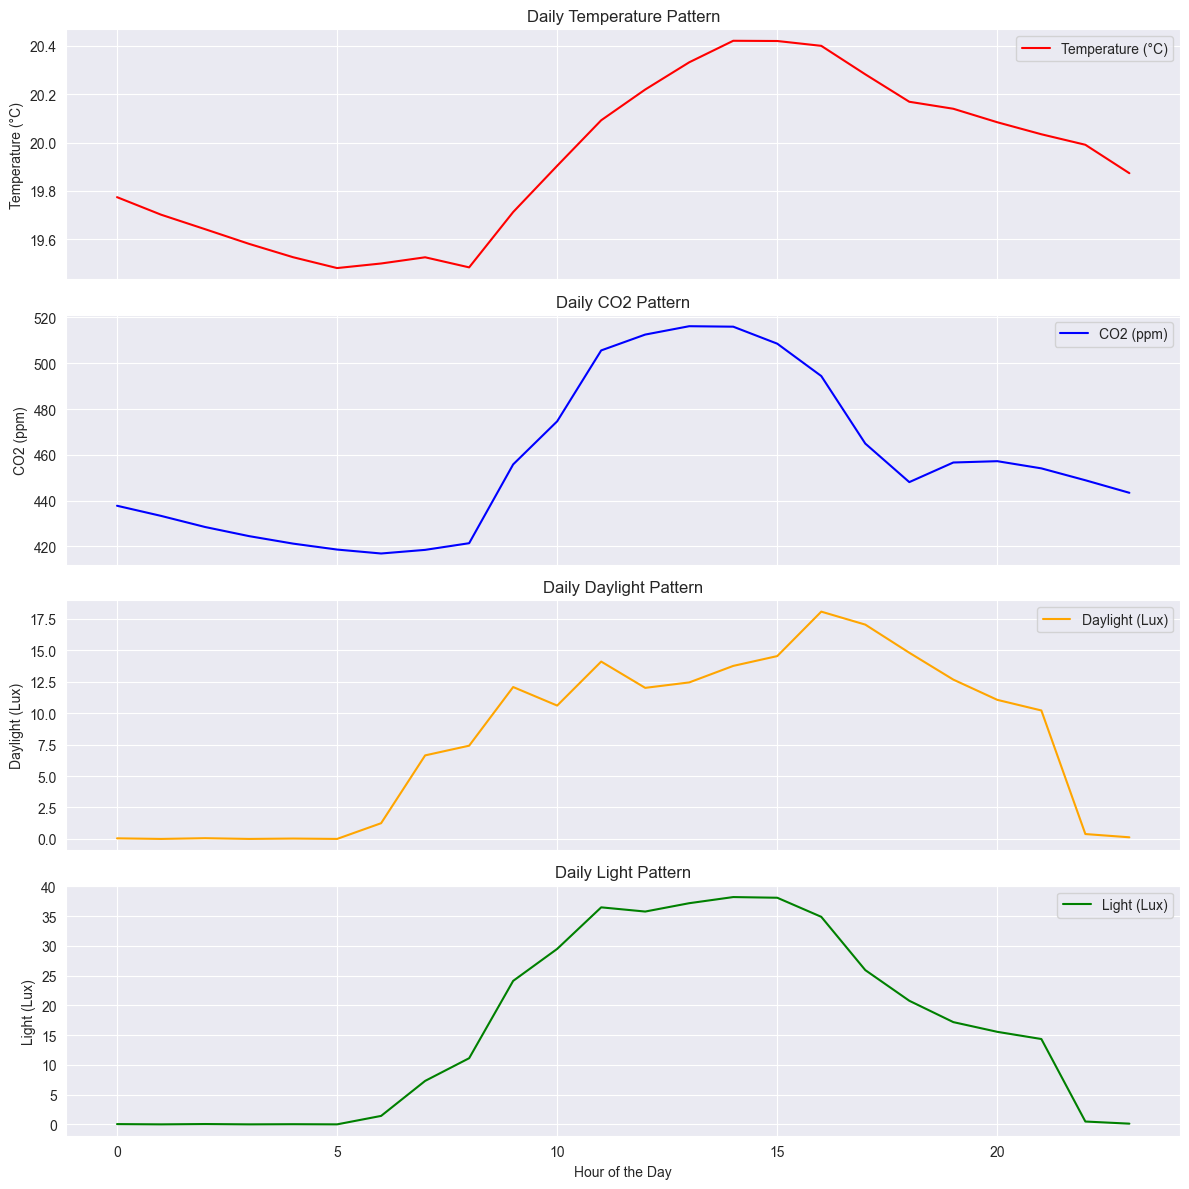

In [14]:
copy = full_df.copy()
copy.set_index('_time', inplace=True)
copy = copy[sensor_columns]

# Extract hour for analysis
copy["_hour"] = copy.index.hour

# Compute daily averages
daily_avg = copy.groupby("_hour").mean()

# Plot daily trends
fig, axes = plt.subplots(4, 1, figsize=(12, 12), sharex=True)

# Temperature
axes[0].plot(daily_avg.index, daily_avg["temperature"], color="red", label="Temperature (°C)")
axes[0].set_title("Daily Temperature Pattern")
axes[0].set_ylabel("Temperature (°C)")
axes[0].legend()

# Air Quality (CO₂)
axes[1].plot(daily_avg.index, daily_avg["airquality"], color="blue", label="CO2 (ppm)")
axes[1].set_title("Daily CO2 Pattern")
axes[1].set_ylabel("CO2 (ppm)")
axes[1].legend()

# Daylight
axes[2].plot(daily_avg.index, daily_avg["daylight"], color="orange", label="Daylight (Lux)")
axes[2].set_title("Daily Daylight Pattern")
axes[2].set_ylabel("Daylight (Lux)")
axes[2].legend()

# Light
axes[3].plot(daily_avg.index, daily_avg["light"], color="green", label="Light (Lux)")
axes[3].set_title("Daily Light Pattern")
axes[3].set_ylabel("Light (Lux)")
axes[3].set_xlabel("Hour of the Day")
axes[3].legend()

plt.tight_layout()
plt.show()

#### Weekend vs. Weekday Trends

As one would expect, higher sensor readings can be obtained during the weekday, when the office is occupied

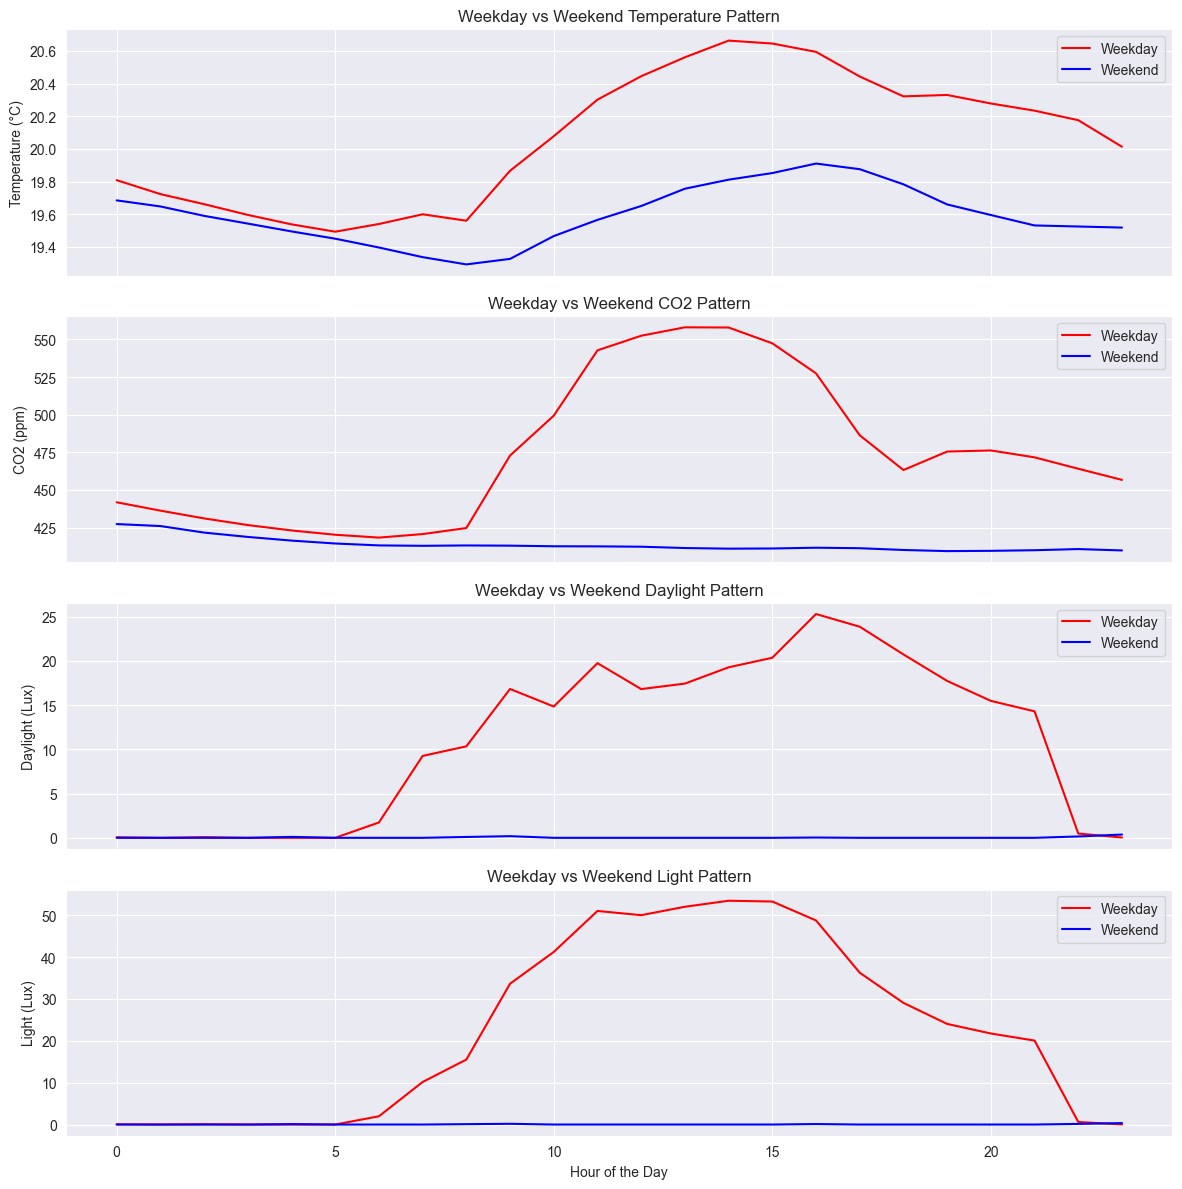

In [15]:
copy = full_df.copy()
copy.set_index('_time', inplace=True)
copy = copy[sensor_columns]

# Extract date and hour for daily analysis
copy["_hour"] = copy.index.hour
copy["_date"] = copy.index.date

# Extract weekday information (0=Monday, 6=Sunday)
copy["_weekday"] = copy.index.weekday
copy["_day_type"] = copy['_weekday'].apply(lambda x: "Weekend" if x >= 5 else "Weekday")

# Compute weekday/weekend averages
weekday_avg = copy[copy["_day_type"] == "Weekday"].groupby("_hour")[sensor_columns].mean()
weekend_avg = copy[copy["_day_type"] == "Weekend"].groupby("_hour")[sensor_columns].mean()

# Plot weekday vs weekend trends
fig, axes = plt.subplots(4, 1, figsize=(12, 12), sharex=True)

# Temperature
axes[0].plot(weekday_avg.index, weekday_avg["temperature"], color="red", label="Weekday")
axes[0].plot(weekend_avg.index, weekend_avg["temperature"], color="blue", label="Weekend")
axes[0].set_title("Weekday vs Weekend Temperature Pattern")
axes[0].set_ylabel("Temperature (°C)")
axes[0].legend()

# Air Quality (CO₂)
axes[1].plot(weekday_avg.index, weekday_avg["airquality"], color="red", label="Weekday")
axes[1].plot(weekend_avg.index, weekend_avg["airquality"], color="blue", label="Weekend")
axes[1].set_title("Weekday vs Weekend CO2 Pattern")
axes[1].set_ylabel("CO2 (ppm)")
axes[1].legend()

# Daylight
axes[2].plot(weekday_avg.index, weekday_avg["daylight"], color="red", label="Weekday")
axes[2].plot(weekend_avg.index, weekend_avg["daylight"], color="blue", label="Weekend")
axes[2].set_title("Weekday vs Weekend Daylight Pattern")
axes[2].set_ylabel("Daylight (Lux)")
axes[2].legend()

# Light
axes[3].plot(weekday_avg.index, weekday_avg["light"], color="red", label="Weekday")
axes[3].plot(weekend_avg.index, weekend_avg["light"], color="blue", label="Weekend")
axes[3].set_title("Weekday vs Weekend Light Pattern")
axes[3].set_ylabel("Light (Lux)")
axes[3].set_xlabel("Hour of the Day")
axes[3].legend()

plt.tight_layout()
plt.show()

### Sensor Values During Lectures vs. Non-Lecture Times

#### Comparision of sensor readings

Some insights from the below comparison are:
- CO2 buildup seems to indicate room occupancy
- Temperature rises only very slightly between both states. This indicates good ventilation
- Daylight and lighting patterns both align with scheduled occupancy

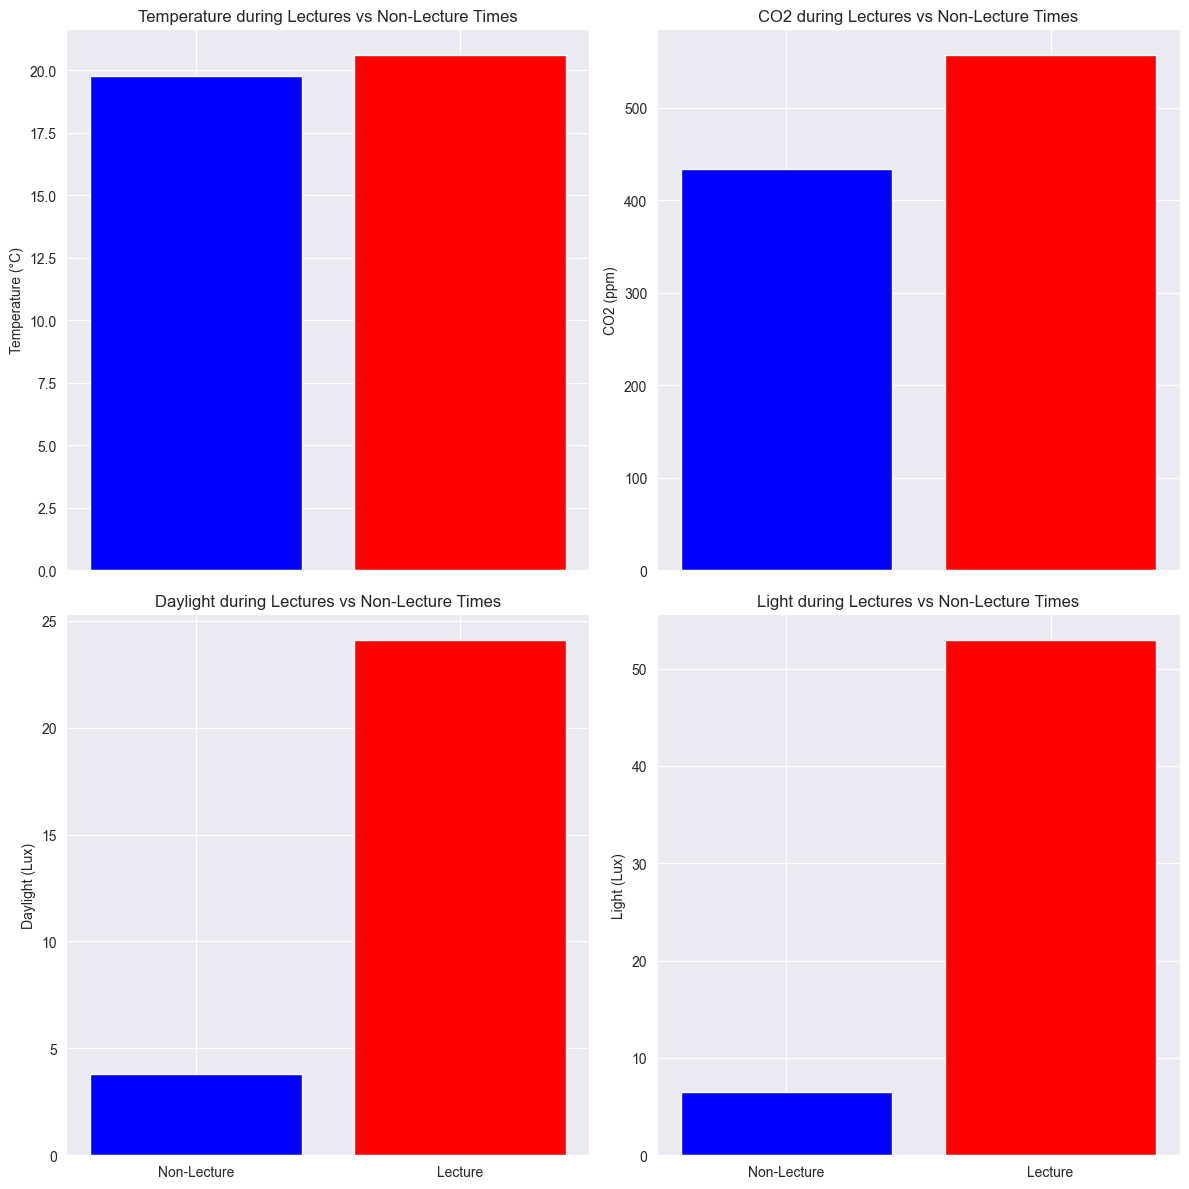

In [13]:
# Group by lecture scheduled and compute averages
sensor_comparision = full_df.groupby("Occupancy")[sensor_columns].mean()

# Plot sensor values during lectures vs non-lecture times
fig, axes = plt.subplots(2, 2, figsize=(12, 12), sharex=True)

# Temperature
axes[0, 0].bar(["Non-Lecture", "Lecture"], sensor_comparision["temperature"], color=["blue", "red"])
axes[0, 0].set_title("Temperature during Lectures vs Non-Lecture Times")
axes[0, 0].set_ylabel("Temperature (°C)")

# Air Quality (CO2)
axes[0, 1].bar(["Non-Lecture", "Lecture"], sensor_comparision["airquality"], color=["blue", "red"])
axes[0, 1].set_title("CO2 during Lectures vs Non-Lecture Times")
axes[0, 1].set_ylabel("CO2 (ppm)")

# Daylight
axes[1, 0].bar(["Non-Lecture", "Lecture"], sensor_comparision["daylight"], color=["blue", "red"])
axes[1, 0].set_title("Daylight during Lectures vs Non-Lecture Times")
axes[1, 0].set_ylabel("Daylight (Lux)")

# Light
axes[1, 1].bar(["Non-Lecture", "Lecture"], sensor_comparision["light"], color=["blue", "red"])
axes[1, 1].set_title("Light during Lectures vs Non-Lecture Times")
axes[1, 1].set_ylabel("Light (Lux)")

plt.tight_layout()
plt.show()

#### Correlation between sensors and when a lecture is scheduled

From the below heatmap, it seems that lighting is the strongest indicator of occupancy, with the other three sensor readings having a somewhat equal amount of correlation.

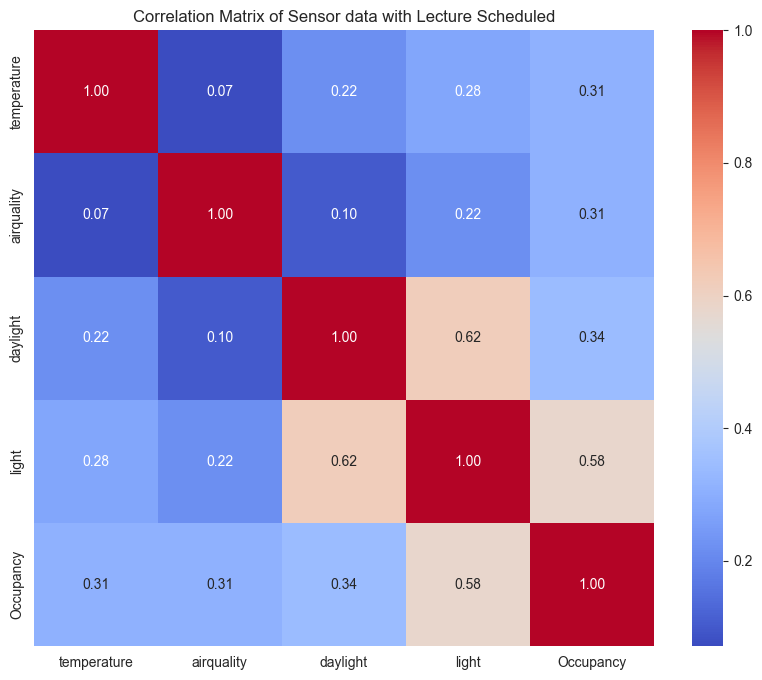

In [15]:
# Correlation Analysis between sensors and lecture scheduled
copy = full_df.copy()
copy["Occupancy"] = copy["Occupancy"].astype(int)

# Compute correlation matrix
sensor_columns_with_lecture = sensor_columns + ["Occupancy"]
correlation_matrix_with_lecture = copy[sensor_columns_with_lecture].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_with_lecture, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Sensor data with Lecture Scheduled")
plt.show()

### CO2 Delay Effects - Checking how long it takes for CO2 levels to increase during a lecture / return to 'normal' after a lecture

In [16]:
# Create shifted versions of lecture_schedules to compare previous states
shifted_copy = full_df.copy()
shifted_copy["prev_state"] = shifted_copy['Occupancy'].shift(1, fill_value=False)

# Define lecture start and lecture end conditions
shifted_copy['lecture_start'] = (shifted_copy["Occupancy"] == 1) & (shifted_copy["prev_state"] == 0)
shifted_copy['lecture_end'] = (shifted_copy["Occupancy"] == 0) & (shifted_copy["prev_state"] == 1)

# Display rows where lecture starts or ends
display(shifted_copy.loc[(shifted_copy["lecture_start"]) | (shifted_copy["lecture_end"]), ["_time", "lecture_start", "lecture_end", "room_number"]])

,_time,lecture_start,lecture_end,room_number
420,2024-10-01 09:00:00+00:00,True,False,Room_01
660,2024-10-01 13:00:00+00:00,False,True,Room_01
780,2024-10-01 15:00:00+00:00,True,False,Room_01
1019,2024-10-01 19:00:00+00:00,False,True,Room_01
1856,2024-10-02 09:00:00+00:00,True,False,Room_01
...,...,...,...,...
3029757,2025-03-27 11:00:00+00:00,False,True,Room_11
3034835,2025-03-31 11:01:00+00:00,True,False,Room_11
3034889,2025-03-31 12:02:00+00:00,False,True,Room_11
3034942,2025-03-31 13:00:00+00:00,True,False,Room_11


#### Check CO2 levels before and during a lecture

CO2 levels seem to rise immediately after a lecture starts for all rooms, which confirms its impact.

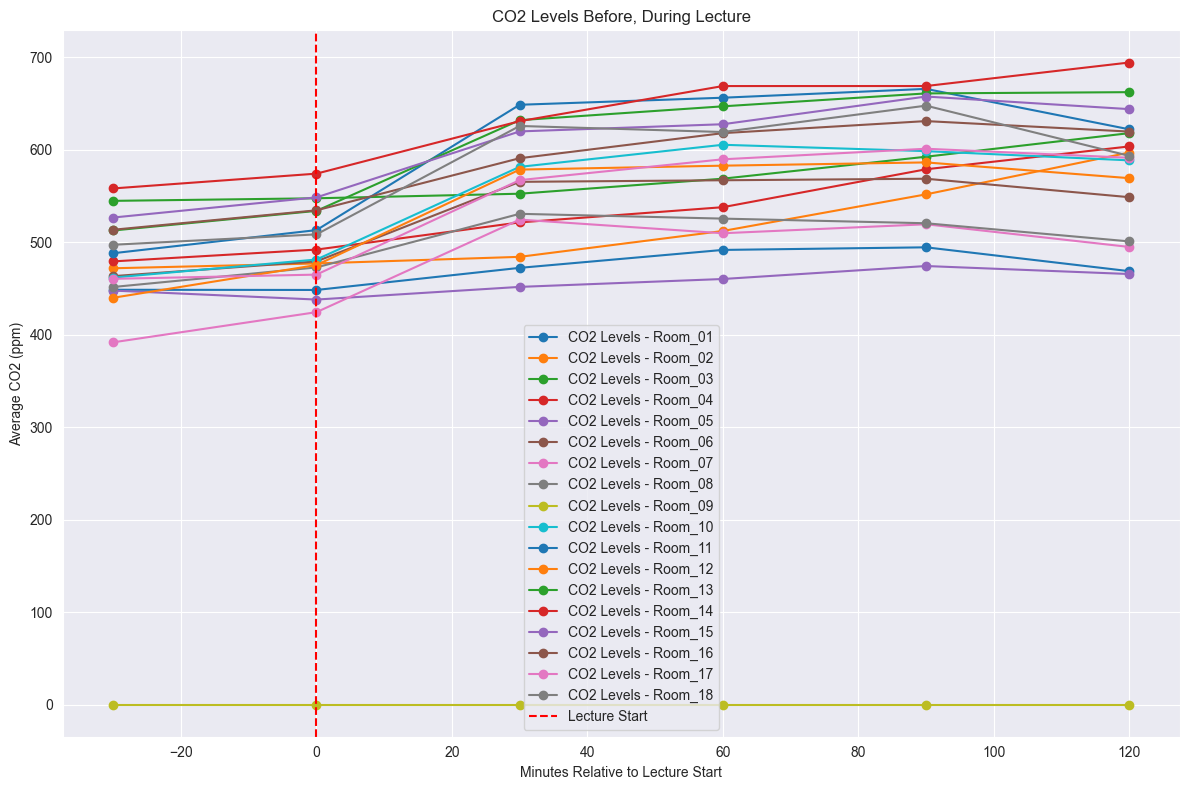

In [17]:
# Define time offsets (before, during lecture)
time_window = [-30, 0, 30, 60, 90, 120]
room_co2_trends = {}

# Copy the DataFrame
copy = shifted_copy.copy()

# Get room numbers
rooms = copy["room_number"].unique()

# Iterate through rooms
for room in rooms:
    co2_trends = []

    # Filter data for each room
    room_df = copy[copy["room_number"] == room].copy()

    # Drop duplicate timestamps just in case (keep the first occurrence)
    room_df = room_df.drop_duplicates(subset=["_time"])

    # Set time as index
    room_df.set_index("_time", inplace=True)

    for offset in time_window:
        # Create a temporary copy of the filtered data
        shifted_room_df = room_df.copy()

        # Shift CO₂ values relative to lecture start times
        shifted_room_df["shifted_co2"] = shifted_room_df["airquality"].shift(periods=-offset, freq="min")

        # Keep only rows where a lecture is starting
        filtered_shifted = shifted_room_df[shifted_room_df["lecture_start"]]

        # Compute mean CO₂ for this offset
        avg_co2 = filtered_shifted["shifted_co2"].mean()
        co2_trends.append(avg_co2)

    # Store CO₂ trends for this room
    room_co2_trends[room] = co2_trends

# Plot CO₂ levels over time for each room
plt.figure(figsize=(12, 8))
for room, trends in room_co2_trends.items():
    plt.plot(time_window, trends, marker='o', linestyle='-', label=f"CO2 Levels - {room}")

# Add lecture start marker
plt.axvline(x=0, color="red", linestyle="--", label="Lecture Start")

# Labels and title
plt.xlabel("Minutes Relative to Lecture Start")
plt.ylabel("Average CO2 (ppm)")
plt.title("CO2 Levels Before, During Lecture")
plt.legend()
plt.tight_layout()
plt.show()

#### Check CO2 levels during and after a lecture

CO2 levels seem to drop right after a lecture with varying decay rates across the rooms, possibly due to differences in ventilation.

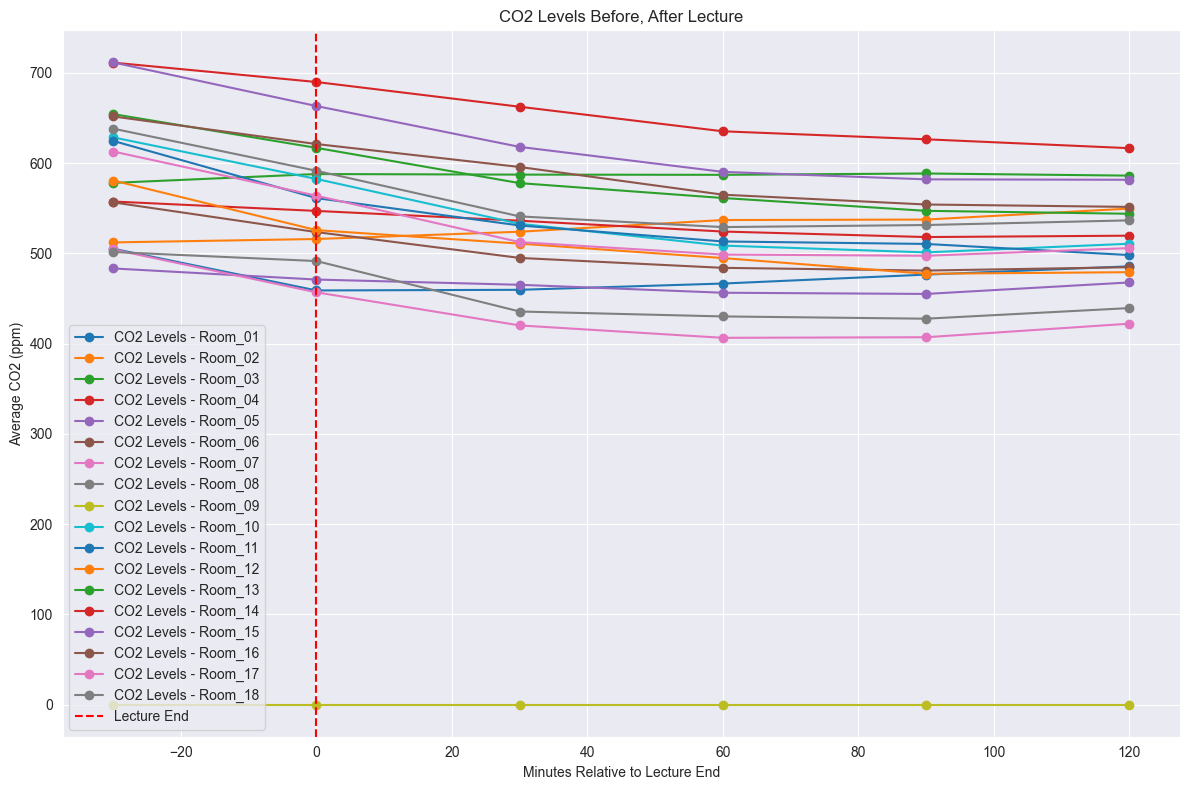

In [18]:
# Define time offsets (during, and after lecture)
time_window = [-30, 0, 30, 60, 90, 120]
room_co2_trends = {}

# Copy the DataFrame
copy = shifted_copy.copy()

# Get room numbers
rooms = copy["room_number"].unique()

# Iterate through rooms
for room in rooms:
    co2_trends = []

    # Filter data for each room
    room_df = copy[copy["room_number"] == room].copy()

    # Drop duplicate timestamps (keep the first occurrence)
    room_df = room_df.drop_duplicates(subset=["_time"])

    # Set time as index
    room_df.set_index("_time", inplace=True)

    for offset in time_window:
        # Create a temporary copy of the filtered data
        shifted_room_df = room_df.copy()

        # Shift CO₂ values relative to lecture start times
        shifted_room_df["shifted_co2"] = shifted_room_df["airquality"].shift(periods=-offset, freq="min")

        # Keep only rows where a lecture is starting
        filtered_shifted = shifted_room_df[shifted_room_df["lecture_end"]]

        # Compute mean CO₂ for this offset
        avg_co2 = filtered_shifted["shifted_co2"].mean()
        co2_trends.append(avg_co2)

    # Store CO₂ trends for this room
    room_co2_trends[room] = co2_trends

# Plot CO₂ levels over time for each room
plt.figure(figsize=(12, 8))
for room, trends in room_co2_trends.items():
    plt.plot(time_window, trends, marker='o', linestyle='-', label=f"CO2 Levels - {room}")

# Add lecture start marker
plt.axvline(x=0, color="red", linestyle="--", label="Lecture End")

# Labels and title
plt.xlabel("Minutes Relative to Lecture End")
plt.ylabel("Average CO2 (ppm)")
plt.title("CO2 Levels Before, After Lecture")
plt.legend()
plt.tight_layout()
plt.show()

### Room Specific Comparisions

#### Clustering Rooms based on Sensor Data

Due to Room_09 having a lot of missing data, it is dropped for the purposes of this analysis. Looking at the cluster analysis, some interesting information can be gained.
- **Cluster 0:** Cluster including most rooms, with capacities ranging from 18 to 40. Overall, it seems that these rooms have fewer lectures scheduled in comparison to other rooms. As a result of this, CO2 levels seem to be more stable
- **Cluster 1:** Includes rooms with moderate occupancy schedules. Thus, there might be more fluctuations in CO2 and temperature patterns.
- **Cluster 2:** Includes 2 rooms with the highest capacities (Room_06 [160] and L1.02 [240]), L1.08 [30] and L2.07 [24]. The inclusion of L2.07 and L1.08 with the larger capacity rooms indicates that the environmental conditions of these rooms are different from rooms with the comparable capacity (more light exposure or better ventilation). Scheduled lecture values are also likely the highest, which would translate into higher CO2 levels.

room_number
Room_10    0
Room_07    0
Room_06    0
Room_18    0
Room_05    1
Room_08    1
Room_17    1
Room_11    1
Room_12    1
Room_13    1
Room_14    1
Room_15    1
Room_16    1
Room_01    1
Room_03    2
Room_02    2
Room_04    2
Name: Cluster, dtype: int32


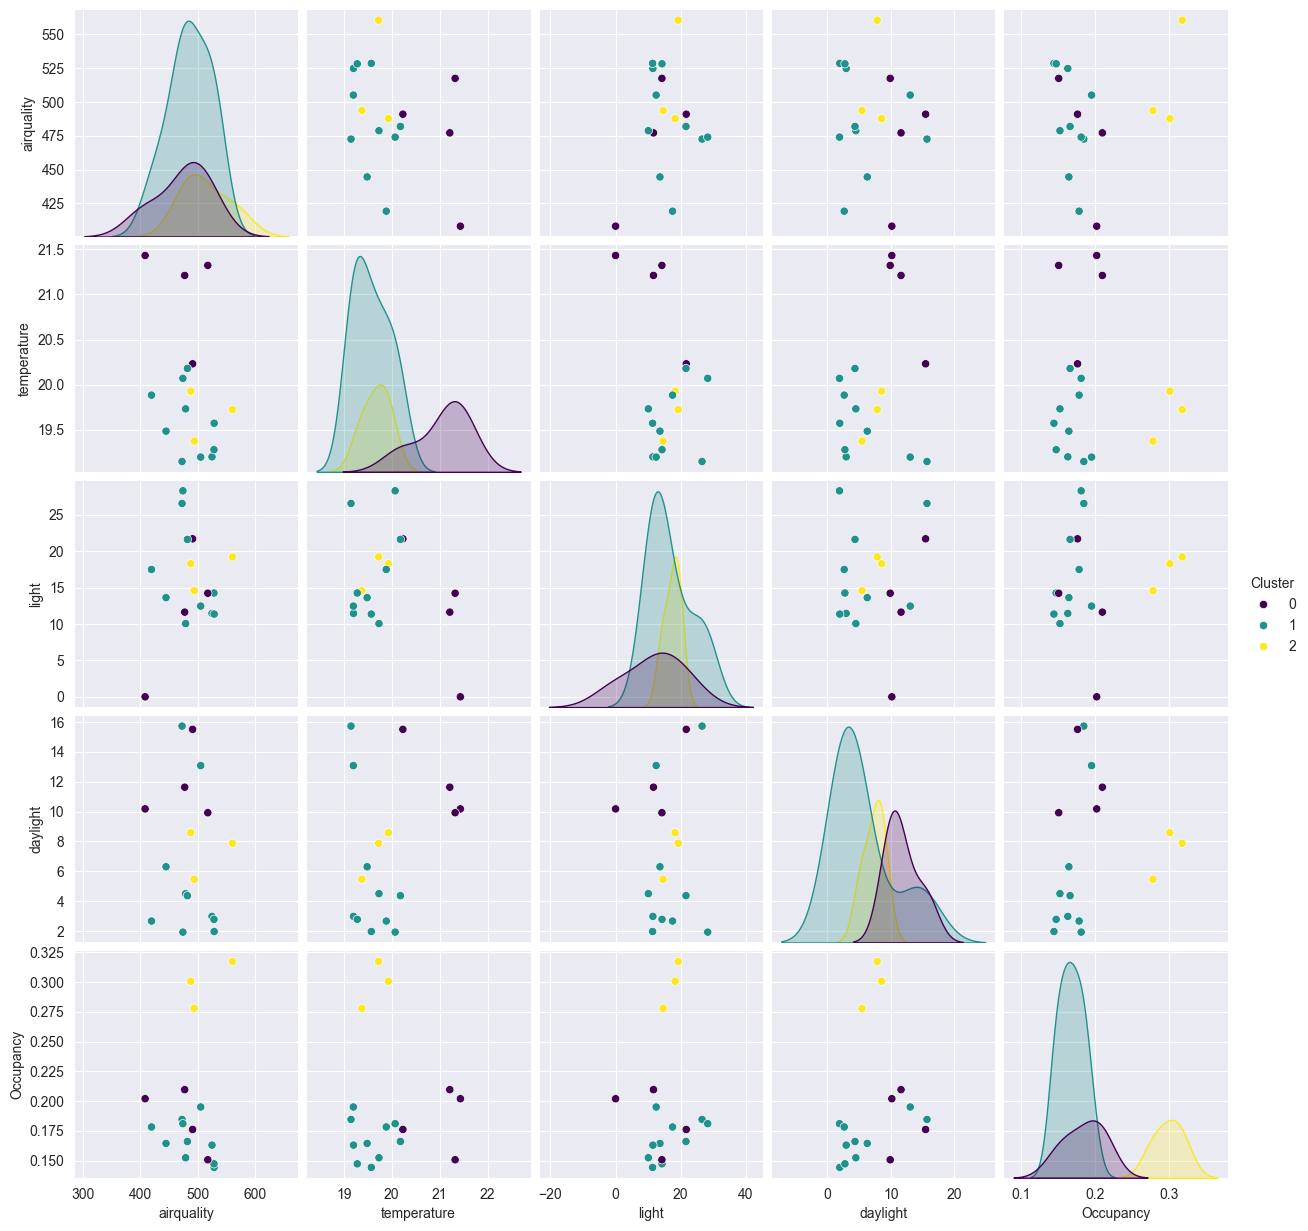

In [19]:
copy = full_df.copy()

# Aggregate sensor data per room
features = ["airquality", "temperature", "light", "daylight", "Occupancy"]
room_aggregates = copy.groupby("room_number")[features].mean()

# Dropping column with room_number Room_09 due to missing data
room_aggregates = room_aggregates.drop("Room_09", axis=0)

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(room_aggregates)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, n_init=10)
room_aggregates["Cluster"] = kmeans.fit_predict(scaled_data)

print(room_aggregates["Cluster"].sort_values())

# Visualize Clusters
sns.pairplot(room_aggregates, hue="Cluster", vars=features, palette="viridis")
plt.show()

#### Comparing Rooms with Different Capacities

Some takeaways from the below diagrams are
- Temperature seems to increase with room size
- CO2 levels are not necessarily higher in larger rooms
- Daylight levels do not follow a clear trend with capacity, which means that the orientation of the room is a big factor
- Lighting is inconsistent, which might be due to sensor placement or daylight compensation.

          temperature  airquality   daylight      light
capacity                                               
18          19.632856  464.967685   5.229378  11.501509
24          19.776430  494.812147   3.190109  16.518287
30          19.941885  360.667030  12.609077  19.211891
32          19.150185  472.594991  15.720842  26.555995
40          19.715740  509.870415   7.504533  17.495127
160         21.208783  477.216301  11.629136  11.629136
240         21.429453  408.174513  10.178485   0.000000


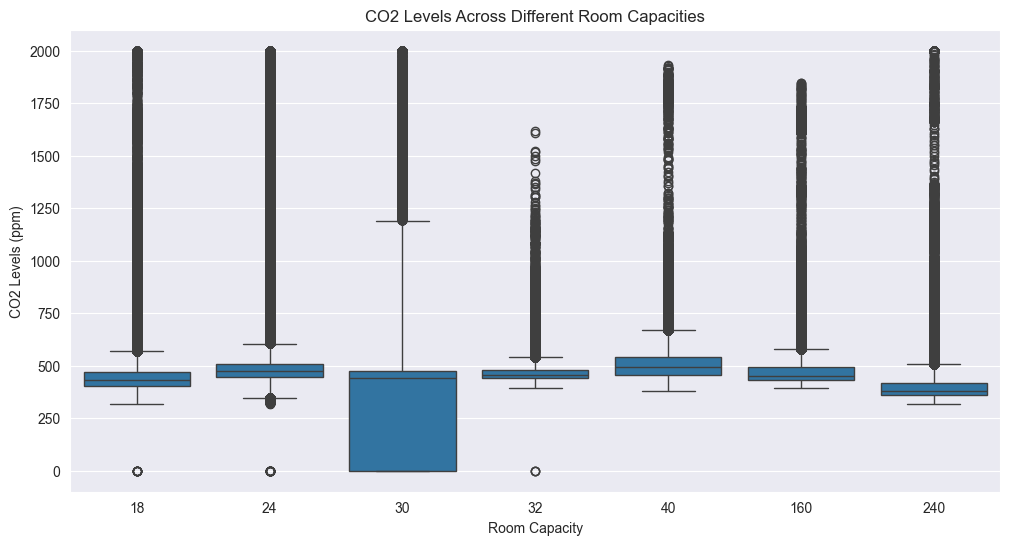

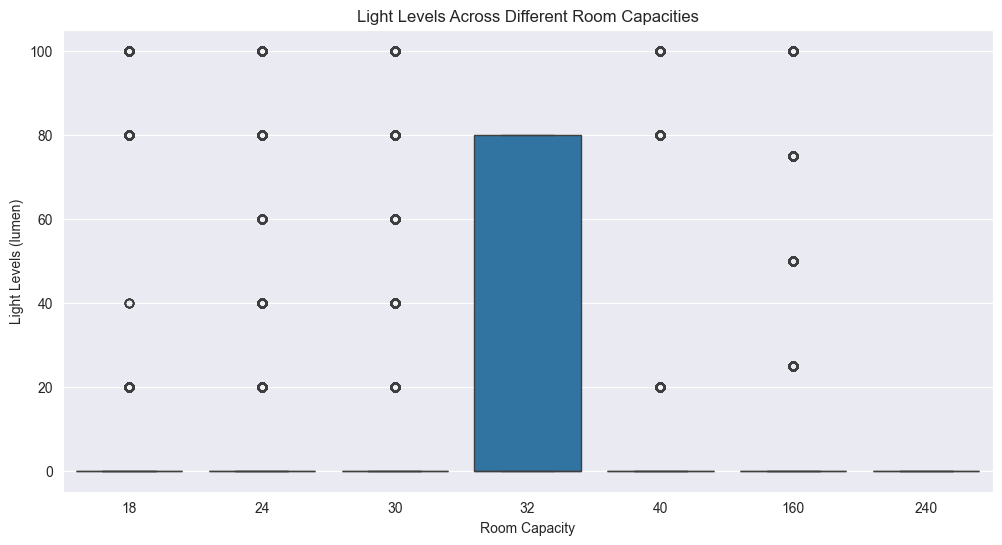

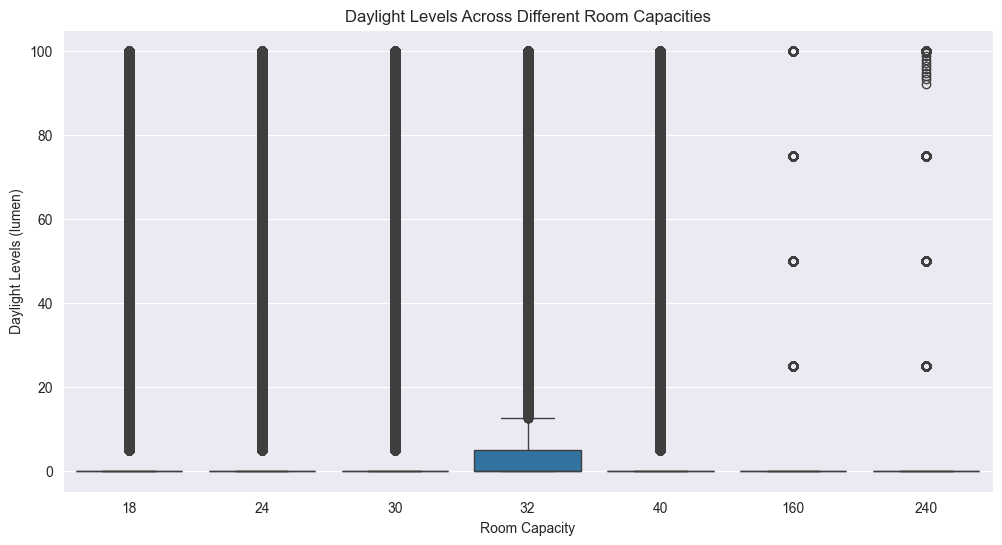

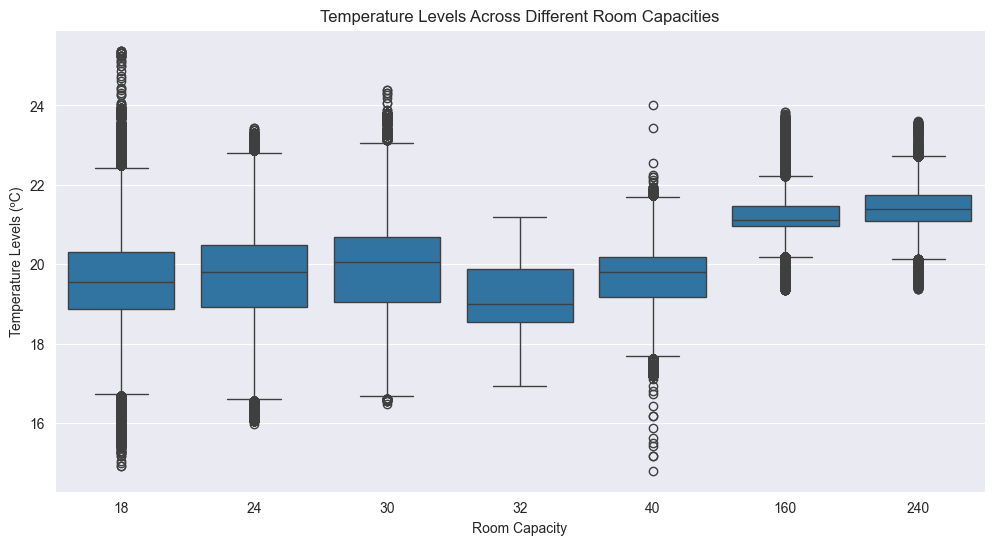

In [20]:
copy = full_df.copy()

# Compute average sensor values for each capacity group
capacity_comparision = full_df.groupby("capacity")[sensor_columns].mean()

print(capacity_comparision)

plt.figure(figsize=(12, 6))
sns.boxplot(x=full_df["capacity"], y=full_df["airquality"])
plt.xlabel("Room Capacity")
plt.ylabel("CO2 Levels (ppm)")
plt.title("CO2 Levels Across Different Room Capacities")
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x=full_df["capacity"], y=full_df["light"])
plt.xlabel("Room Capacity")
plt.ylabel("Light Levels (lumen)")
plt.title("Light Levels Across Different Room Capacities")
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x=full_df["capacity"], y=full_df["daylight"])
plt.xlabel("Room Capacity")
plt.ylabel("Daylight Levels (lumen)")
plt.title("Daylight Levels Across Different Room Capacities")
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x=full_df["capacity"], y=full_df["temperature"])
plt.xlabel("Room Capacity")
plt.ylabel("Temperature Levels (ºC)")
plt.title("Temperature Levels Across Different Room Capacities")
plt.show()

#### Correlation

Some takeaways from the correlation heatmap are:
- Temperature seems to increase with room capacity, probably due to an increase in human activity
- CO2 levels don't seem to be effected too much by capacity, which indicates effective ventilation throughout the building
- Light and daylight sensors seem to be somewhat independent of room size, potentially due to sensor and window placement

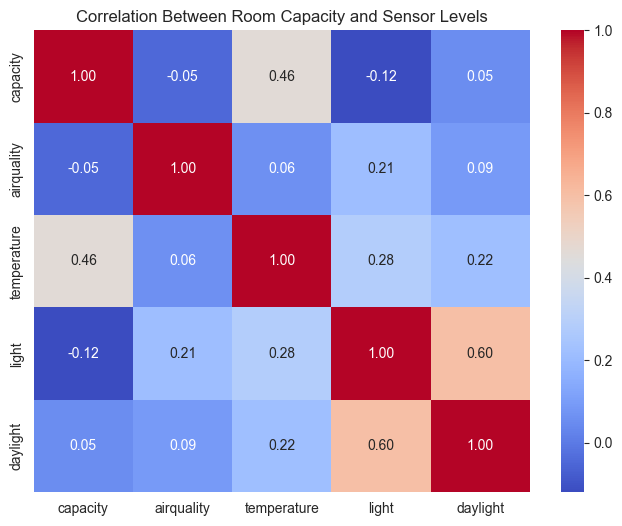

In [24]:
## Correlation between Capacity and Sensor Levels
# Compute correlation
corr_capacity = full_df[["capacity", "airquality", "temperature", "light", "daylight"]].corr()

# Visualize correlation
plt.figure(figsize=(8, 6))
sns.heatmap(corr_capacity, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Room Capacity and Sensor Levels")
plt.show()

## EDA on UCI Sensor Data

Since there is no humidity sensor inside LAB42, the humidity sensor values will be ignored for this EDA.

### Data Loading

In [25]:
# Fetch UCI dataset
uci_df = pd.read_csv('../data/uci_occupancy_dataset/datatraining.txt')

# Convert timestamp to datetime
uci_df['date'] = pd.to_datetime(uci_df['date'])

uci_df

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-04 17:51:00,23.18,27.2720,426.0,721.250000,0.004793,1
2,2015-02-04 17:51:59,23.15,27.2675,429.5,714.000000,0.004783,1
3,2015-02-04 17:53:00,23.15,27.2450,426.0,713.500000,0.004779,1
4,2015-02-04 17:54:00,23.15,27.2000,426.0,708.250000,0.004772,1
5,2015-02-04 17:55:00,23.10,27.2000,426.0,704.500000,0.004757,1
...,...,...,...,...,...,...,...
8139,2015-02-10 09:29:00,21.05,36.0975,433.0,787.250000,0.005579,1
8140,2015-02-10 09:29:59,21.05,35.9950,433.0,789.500000,0.005563,1
8141,2015-02-10 09:30:59,21.10,36.0950,433.0,798.500000,0.005596,1
8142,2015-02-10 09:32:00,21.10,36.2600,433.0,820.333333,0.005621,1


### Basic EDA

#### Check for Class Imbalance

Similar to the LAB42 dataset, there is a large class imbalance for occupancy.

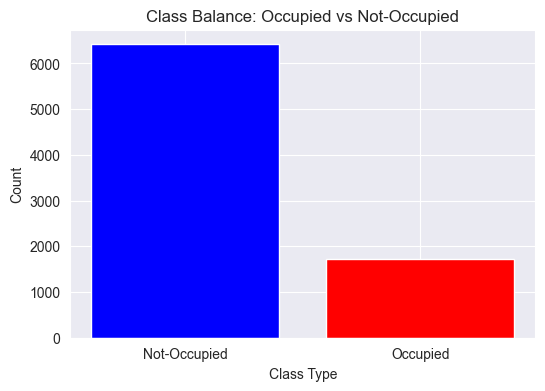

Occupied: 1729 (21.23%)
Not-Occupied: 6414 (78.77%)


In [26]:
# Count occurrences of occupied vs non-occupied
occupied_count = uci_df["Occupancy"].value_counts()

# Plot class balance
plt.figure(figsize=(6, 4))
plt.bar(["Not-Occupied", "Occupied"], occupied_count, color=["blue", "red"])
plt.title("Class Balance: Occupied vs Not-Occupied")
plt.xlabel("Class Type")
plt.ylabel("Count")
plt.show()

# Print proportions
print(f"Occupied: {occupied_count.iloc[1]} ({(occupied_count.iloc[1] / occupied_count.sum()) * 100:.2f}%)")
print(f"Not-Occupied: {occupied_count.iloc[0]} ({(occupied_count.iloc[0] / occupied_count.sum()) * 100:.2f}%)")

#### Check for Missing Values

As can be seen from the diagram, there are no missing values in this dataset

Series([], dtype: int64)


<Axes: >

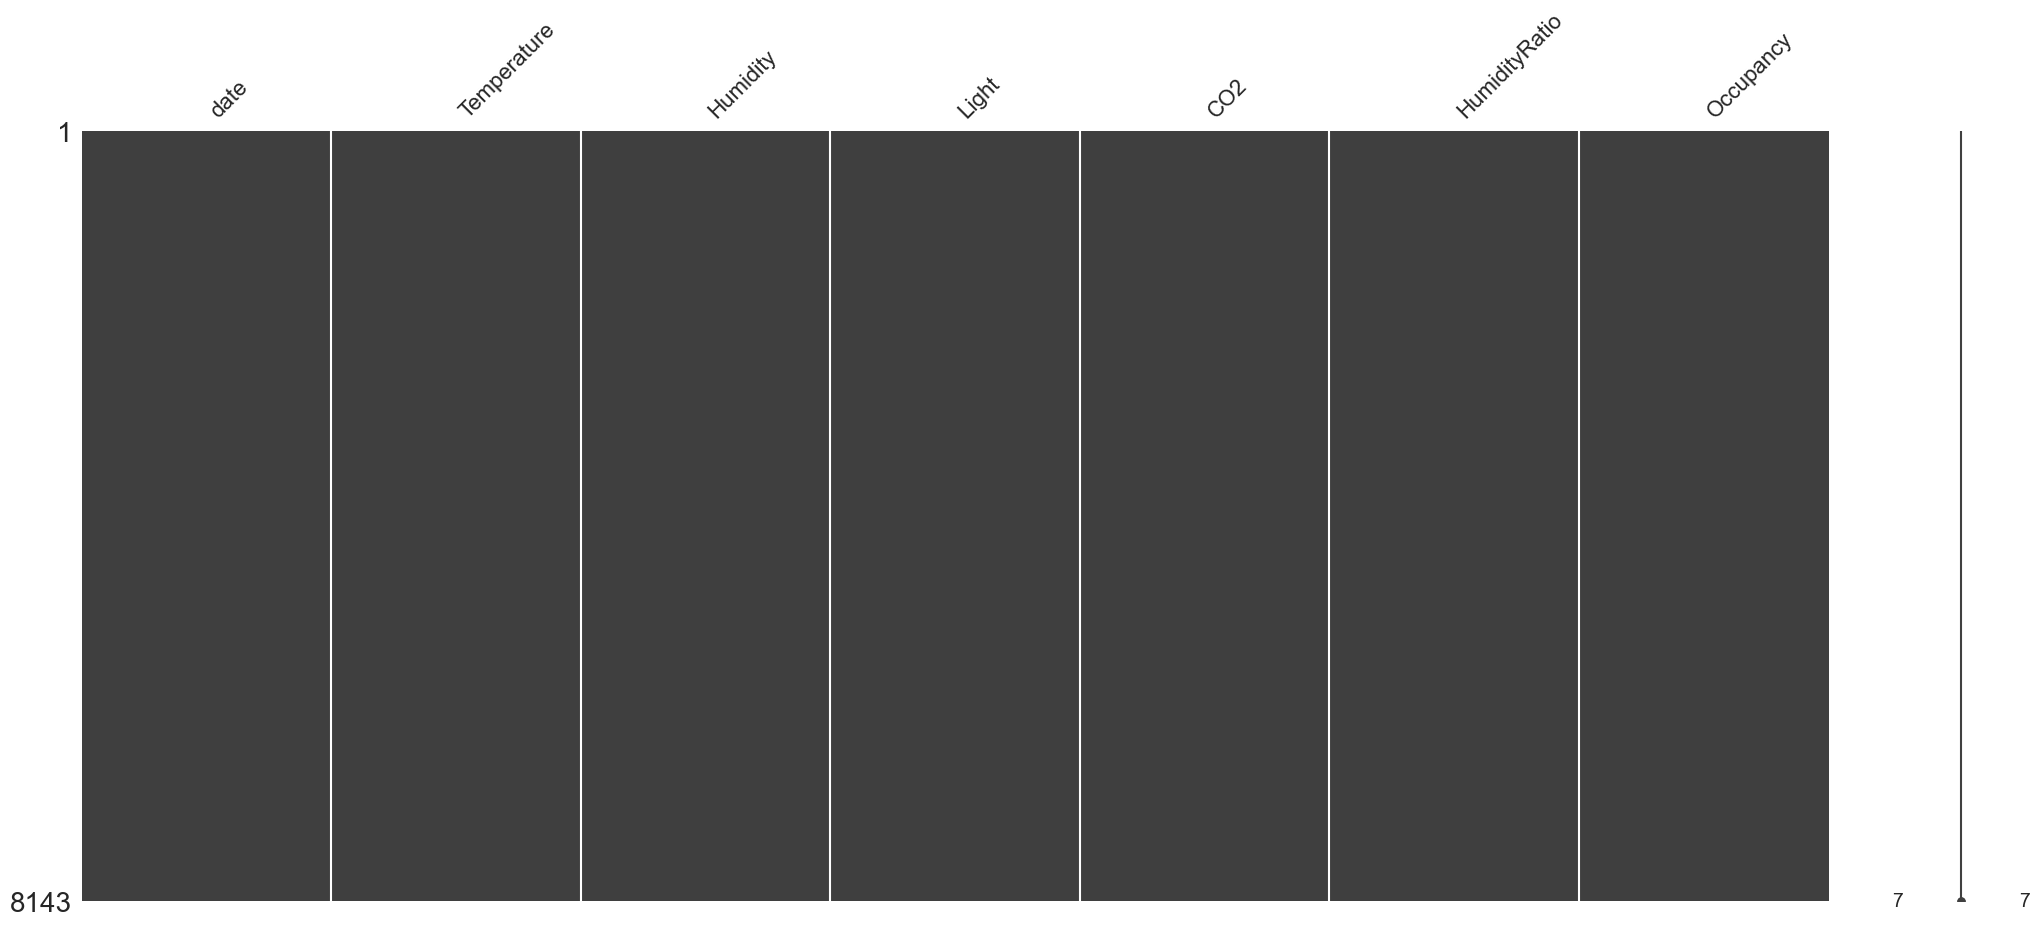

In [27]:
# Check for missing values
missing_values = uci_df.isnull().sum()
print(missing_values[missing_values > 0])  # Only show columns with missing values
msno.matrix(uci_df)

#### Check for Sensor Distribution

The sensor reading distribution for the UCI dataset somewhat matches the LAB42 dataset. Temperature remains mostly stable, with CO2 having some spikes above 1200 ppm, which could indicate poor ventilation or high occupancy. The light sensors for the UCI dataset is lux rather than lumen, but similarities can be seen in that the lights seem to be turned off most of the time, indicating that lights are only used when needed.

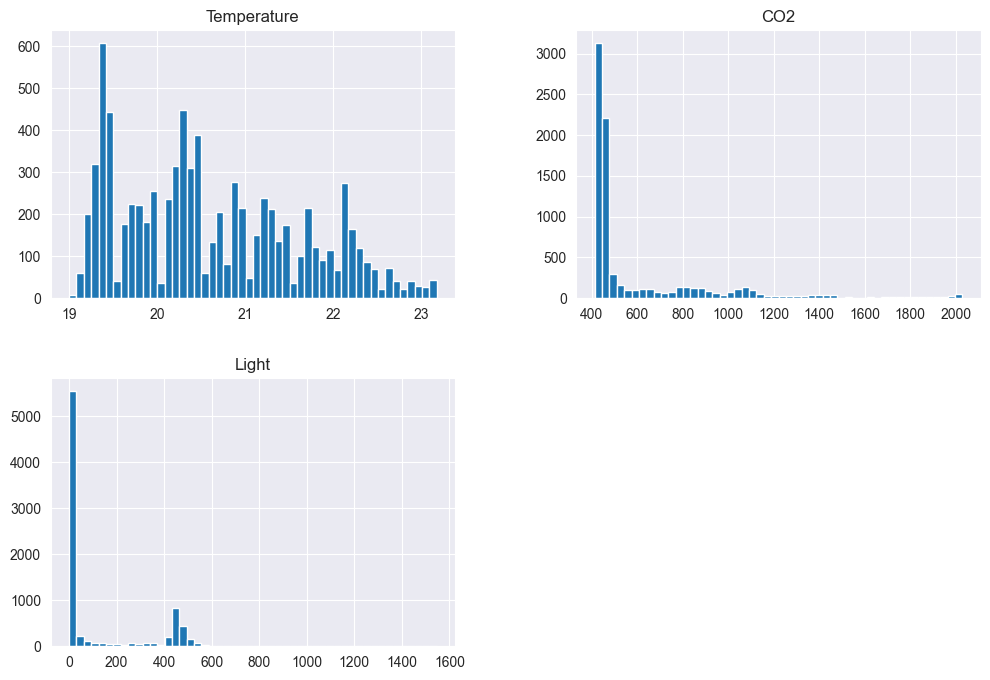

In [28]:
# Relevant sensor distributions
uci_sensor_columns = ["Temperature", "CO2", "Light"]
uci_df[uci_sensor_columns].hist(figsize=(12, 8), bins=50)
plt.show()

#### Check for Outliers

Checking for outliers, we can see that there are a lot of CO2 spikes, which again suggests ventilation inefficiencies. Temperature on the other hand seems to be well regulated, with light having a few high intensity peaks.

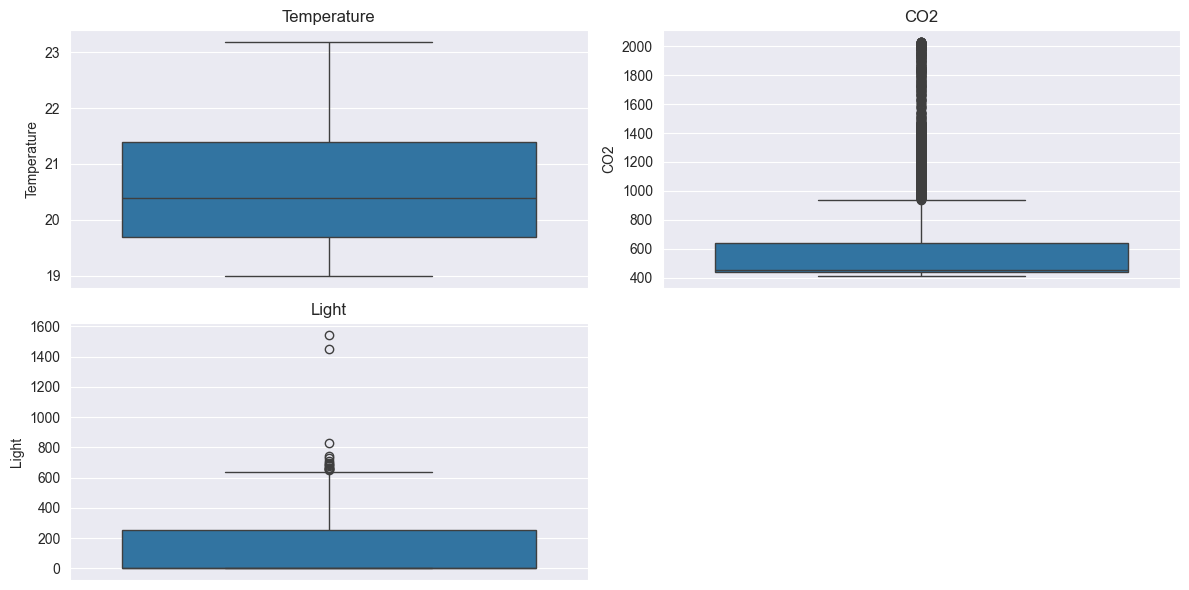

In [29]:
# Looking for any outliers
plt.figure(figsize=(12, 6))
for i, col in enumerate(uci_sensor_columns, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(y=uci_df[col])
    plt.title(col)
plt.tight_layout()
plt.show()

### Temporal Analysis

#### Hourly Trends

In the diagrams below, temperature follows a predictable daily cycle, with CO2 spikes seeming to align with occupied periods. Light also seems to follow clear work-hour patterns.

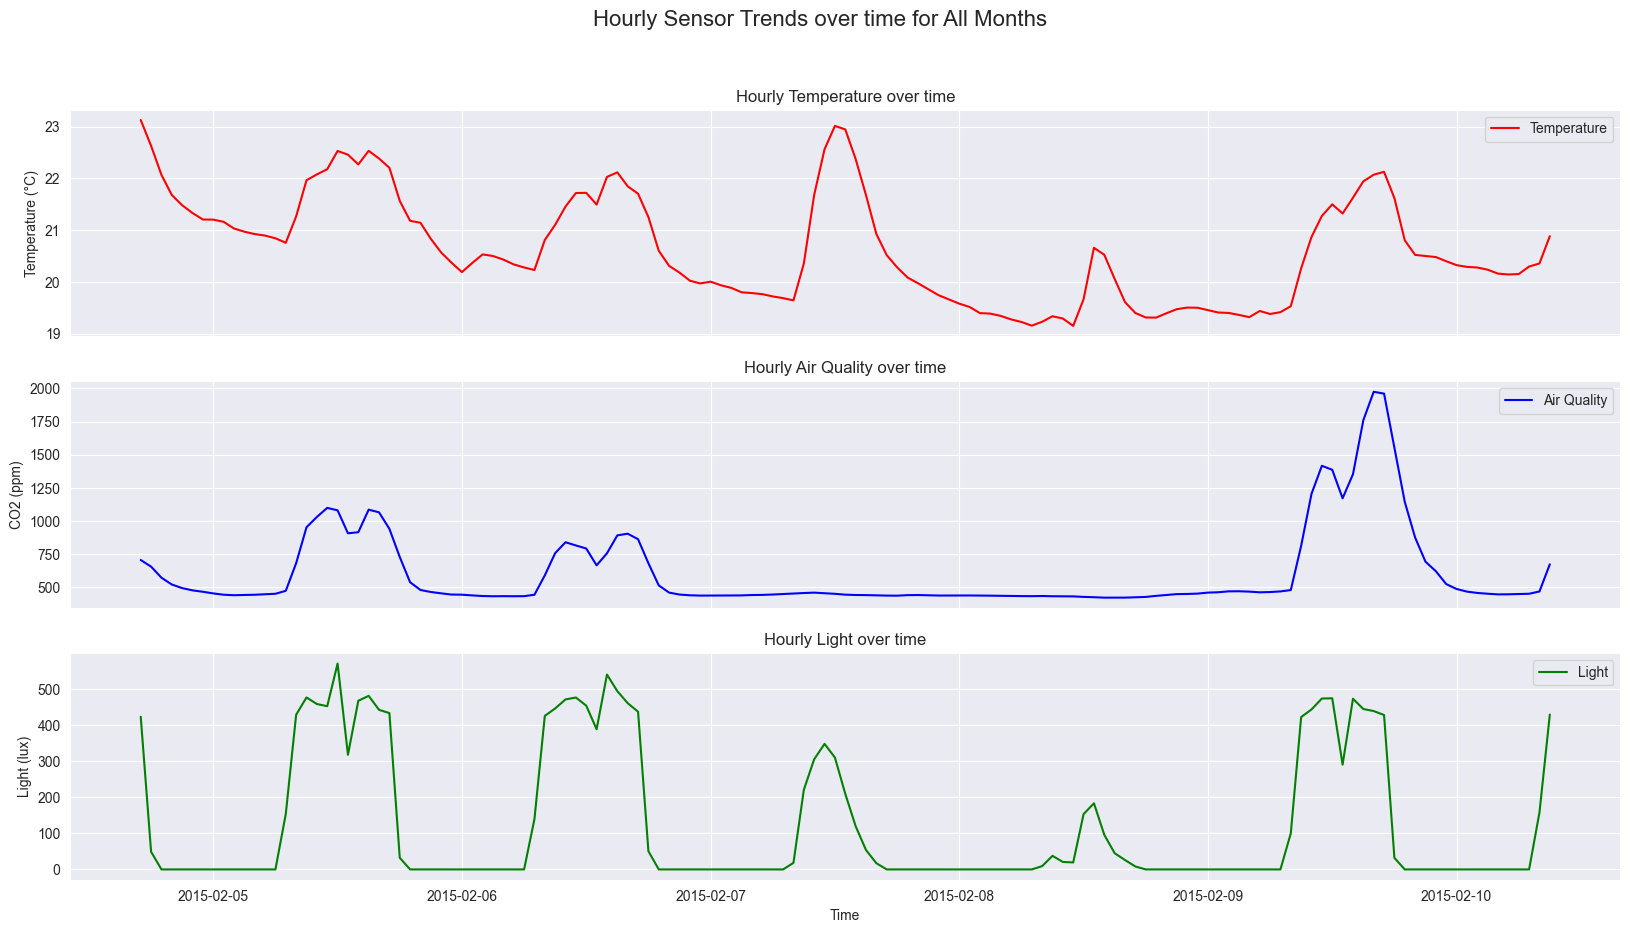

In [30]:
copy = uci_df.copy()
copy.set_index('date', inplace=True)

# Resample data to hourly frequency
uci_df_hourly = copy[uci_sensor_columns].resample('h').mean()

# Plot sensor trends over time
fig, axes = plt.subplots(3, 1, figsize=(20, 10), sharex=True)

# Set title for the figure
fig.suptitle('Hourly Sensor Trends over time for All Months', fontsize=16)
axes[2].set_xlabel('Time')

# Temperature over time
axes[0].plot(uci_df_hourly.index, uci_df_hourly['Temperature'], label='Temperature', color='red')
axes[0].set_title('Hourly Temperature over time')
axes[0].set_ylabel('Temperature (°C)')
axes[0].legend()

# Air Quality over time
axes[1].plot(uci_df_hourly.index, uci_df_hourly['CO2'], label='Air Quality', color='blue')
axes[1].set_title('Hourly Air Quality over time')
axes[1].set_ylabel('CO2 (ppm)')
axes[1].legend()

# Light over time
axes[2].plot(uci_df_hourly.index, uci_df_hourly['Light'], label='Light', color='green')
axes[2].set_title('Hourly Light over time')
axes[2].set_ylabel('Light (lux)')
axes[2].legend()

plt.show()

#### Daily Trends

The daily trends for the UCI dataset show similar shapes to the LAB42 dataset. Temperature steadily increases throughout the day, peaking in the afternoon. CO2 and light levels align with work hours and have similar dips in the afternoon, potentially indicating that the office is not occupied during lunch hours

In [ ]:
%%sql


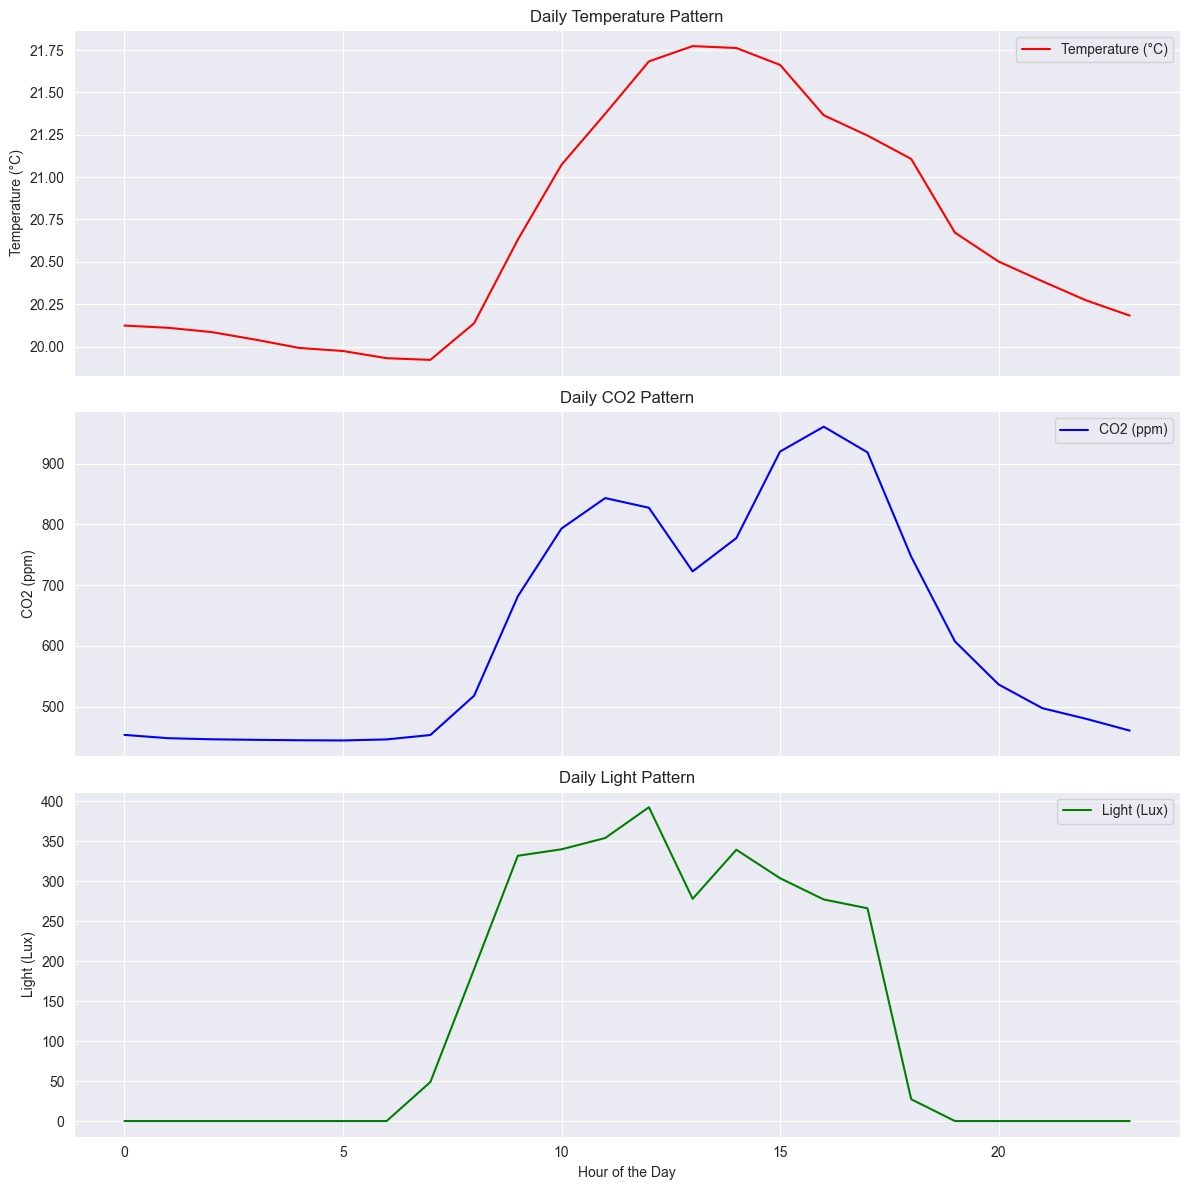

In [31]:
copy = uci_df.copy()
copy.set_index('date', inplace=True)
copy = copy[uci_sensor_columns]

# Extract hour for analysis
copy["_hour"] = copy.index.hour

# Compute daily averages
daily_avg = copy.groupby("_hour").mean()

# Plot daily trends
fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

# Temperature
axes[0].plot(daily_avg.index, daily_avg["Temperature"], color="red", label="Temperature (°C)")
axes[0].set_title("Daily Temperature Pattern")
axes[0].set_ylabel("Temperature (°C)")
axes[0].legend()

# Air Quality (CO₂)
axes[1].plot(daily_avg.index, daily_avg["CO2"], color="blue", label="CO2 (ppm)")
axes[1].set_title("Daily CO2 Pattern")
axes[1].set_ylabel("CO2 (ppm)")
axes[1].legend()

# Light
axes[2].plot(daily_avg.index, daily_avg["Light"], color="green", label="Light (Lux)")
axes[2].set_title("Daily Light Pattern")
axes[2].set_ylabel("Light (Lux)")
axes[2].set_xlabel("Hour of the Day")
axes[2].legend()

plt.tight_layout()
plt.show()

#### Weekday vs Weekend

Below diagram shoes expected results, with sensor readings being higher overall during the weekday. In contrast to LAB42, it seems that the office room for the UCI dataset is used slightly on the weekends, as indicated by the increase of temperature and light. This occupancy is not enough to affect any changes to the CO2.

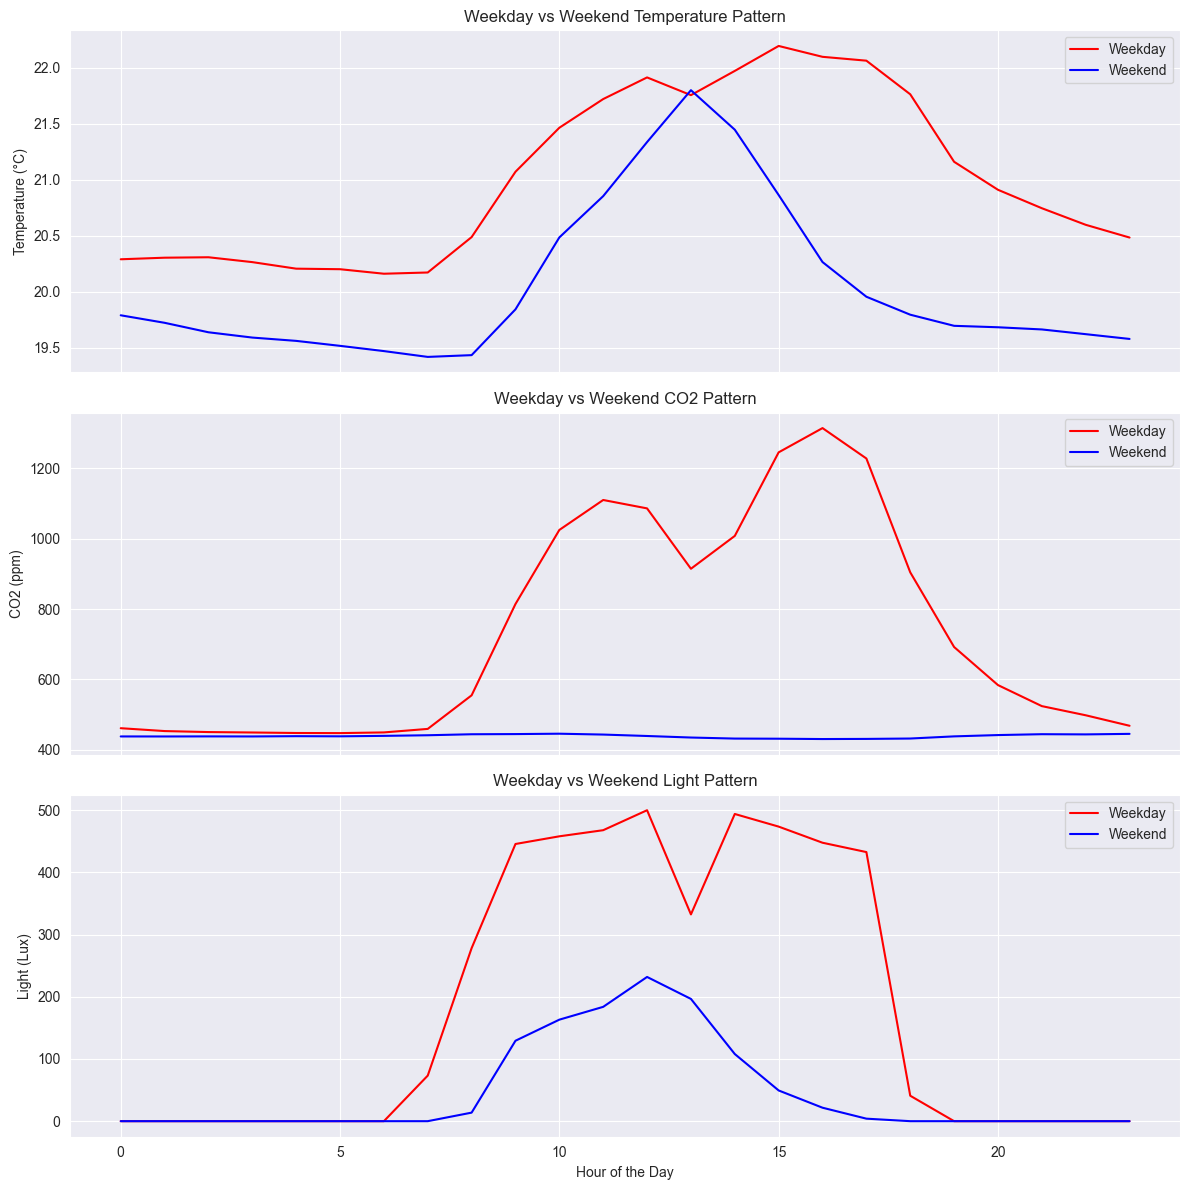

In [32]:
copy = uci_df.copy()
copy.set_index('date', inplace=True)
copy = copy[uci_sensor_columns]

# Extract date and hour for daily analysis
copy["_hour"] = copy.index.hour
copy["_date"] = copy.index.date

# Extract weekday information (0=Monday, 6=Sunday)
copy["_weekday"] = copy.index.weekday
copy["_day_type"] = copy['_weekday'].apply(lambda x: "Weekend" if x >= 5 else "Weekday")

# Compute weekday/weekend averages
weekday_avg = copy[copy["_day_type"] == "Weekday"].groupby("_hour")[uci_sensor_columns].mean()
weekend_avg = copy[copy["_day_type"] == "Weekend"].groupby("_hour")[uci_sensor_columns].mean()

# Plot weekday vs weekend trends
fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

# Temperature
axes[0].plot(weekday_avg.index, weekday_avg["Temperature"], color="red", label="Weekday")
axes[0].plot(weekend_avg.index, weekend_avg["Temperature"], color="blue", label="Weekend")
axes[0].set_title("Weekday vs Weekend Temperature Pattern")
axes[0].set_ylabel("Temperature (°C)")
axes[0].legend()

# Air Quality (CO₂)
axes[1].plot(weekday_avg.index, weekday_avg["CO2"], color="red", label="Weekday")
axes[1].plot(weekend_avg.index, weekend_avg["CO2"], color="blue", label="Weekend")
axes[1].set_title("Weekday vs Weekend CO2 Pattern")
axes[1].set_ylabel("CO2 (ppm)")
axes[1].legend()

# Light
axes[2].plot(weekday_avg.index, weekday_avg["Light"], color="red", label="Weekday")
axes[2].plot(weekend_avg.index, weekend_avg["Light"], color="blue", label="Weekend")
axes[2].set_title("Weekday vs Weekend Light Pattern")
axes[2].set_ylabel("Light (Lux)")
axes[2].set_xlabel("Hour of the Day")
axes[2].legend()

plt.tight_layout()
plt.show()

### Sensor Values During Occupied vs. Non-Occupied Periods

The diagram below matches well to the LAB42 sensor, with all sensor values increases to a varying degree during occupied times.

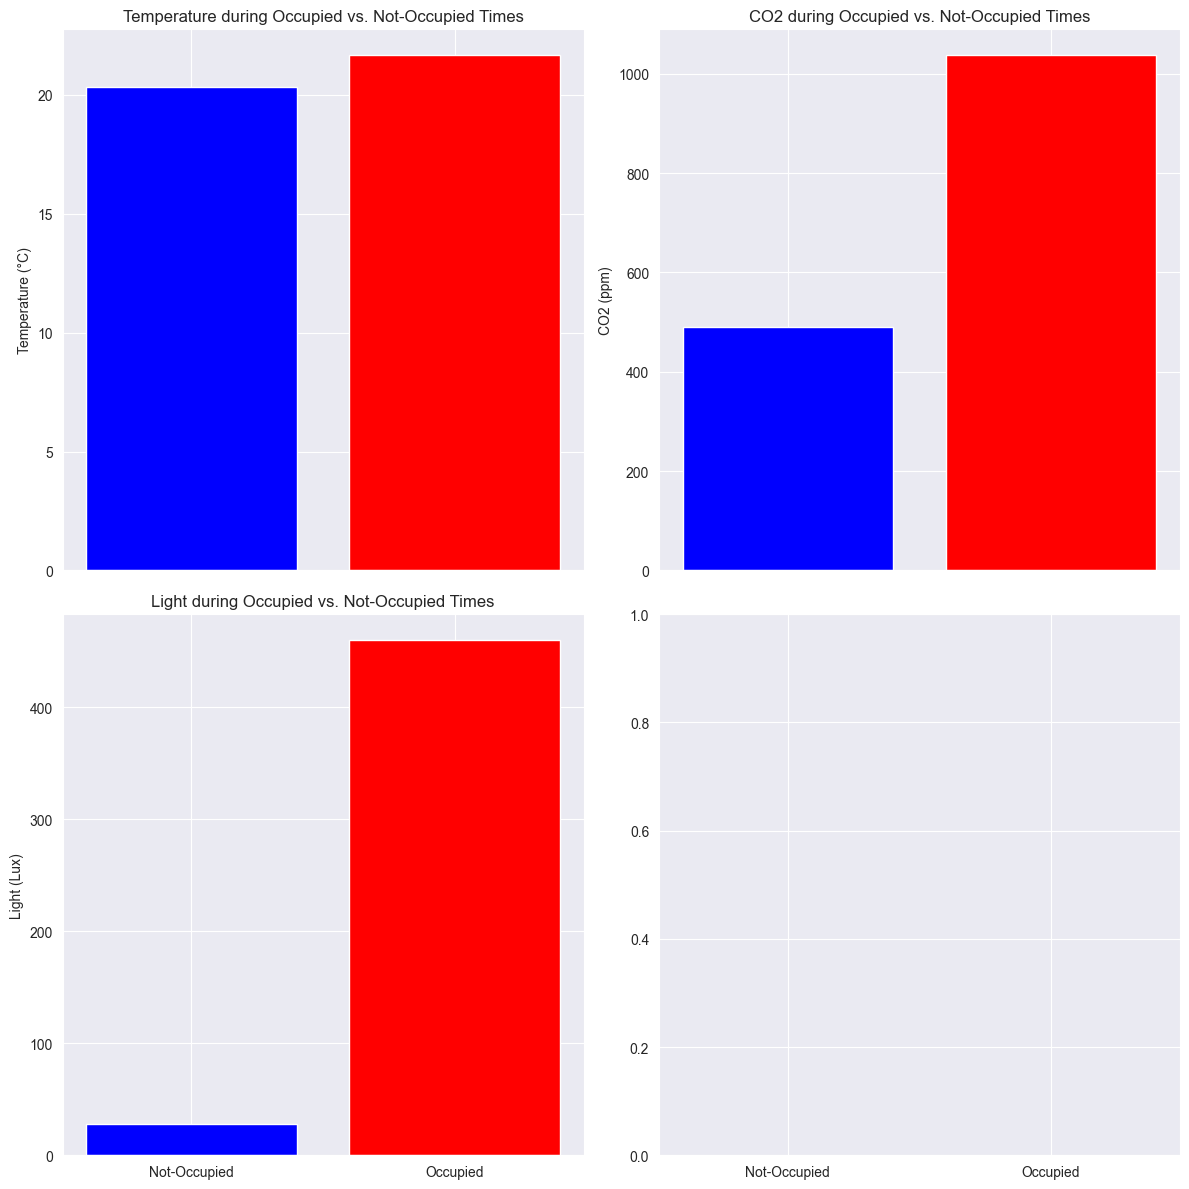

In [33]:
# Group by occupancy and compute averages
uci_sensor_comparision = uci_df.groupby("Occupancy")[uci_sensor_columns].mean()

# Plot sensor values during occupied vs non-occupied times
fig, axes = plt.subplots(2, 2, figsize=(12, 12), sharex=True)

# Temperature
axes[0, 0].bar(["Not-Occupied", "Occupied"], uci_sensor_comparision["Temperature"], color=["blue", "red"])
axes[0, 0].set_title("Temperature during Occupied vs. Not-Occupied Times")
axes[0, 0].set_ylabel("Temperature (°C)")

# Air Quality (CO2)
axes[0, 1].bar(["Not-Occupied", "Occupied"], uci_sensor_comparision["CO2"], color=["blue", "red"])
axes[0, 1].set_title("CO2 during Occupied vs. Not-Occupied Times")
axes[0, 1].set_ylabel("CO2 (ppm)")

# Light
axes[1, 0].bar(["Not-Occupied", "Occupied"], uci_sensor_comparision["Light"], color=["blue", "red"])
axes[1, 0].set_title("Light during Occupied vs. Not-Occupied Times")
axes[1, 0].set_ylabel("Light (Lux)")

plt.tight_layout()
plt.show()

#### Correlation between sensor readings and occupancy

Looking at the heatmap, it seems that light is a very strong indicator for occupancy, with CO2 and temperature also having high correlation values. For this dataset, CO2 and light seem to be very good proxies for occupancy.

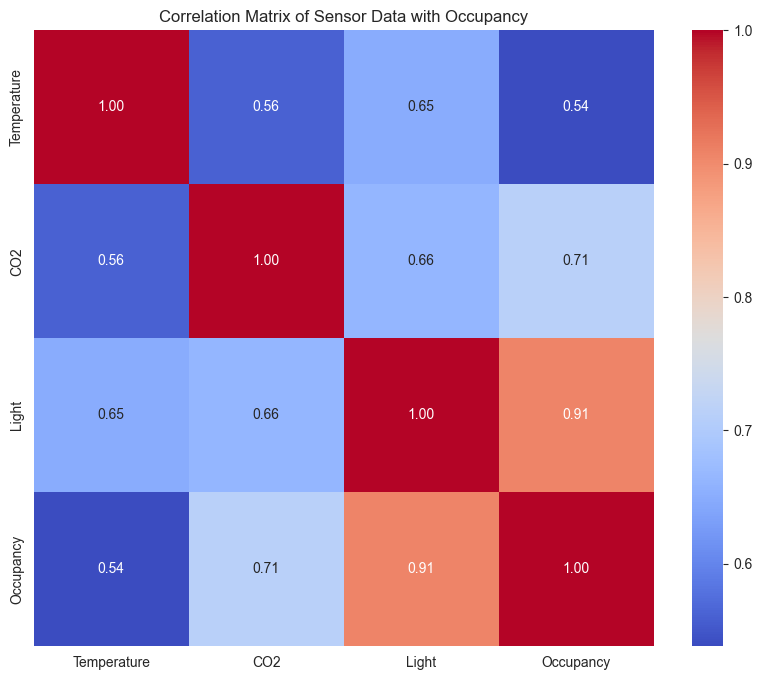

In [34]:
# Correlation Analysis between sensors and occupancy
copy = uci_df.copy()
copy["Occupancy"] = copy["Occupancy"].astype(int)

# Compute correlation matrix
sensor_columns_with_occupancy = uci_sensor_columns + ["Occupancy"]
correlation_matrix_with_occupancy = copy[sensor_columns_with_occupancy].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_with_occupancy, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Sensor data with Occupancy")
plt.show()

### CO2 Delay Effects

In [35]:
# Create shifted versions of lecture_schedules to compare previous states
uci_shifted_copy = uci_df.copy()
uci_shifted_copy["prev_state"] = uci_shifted_copy['Occupancy'].shift(1, fill_value=False)

# Define lecture start and lecture end conditions
uci_shifted_copy['occupancy_start'] = (uci_shifted_copy["Occupancy"] == True) & (uci_shifted_copy["prev_state"] == False)
uci_shifted_copy['occupancy_end'] = (uci_shifted_copy["Occupancy"] == False) & (uci_shifted_copy["prev_state"] == True)

#### Check CO2 levels before and during occupancy

The CO2 levels seem to steadily rise after occupancy starts, peaking at 1050 ppm 3 hours in.

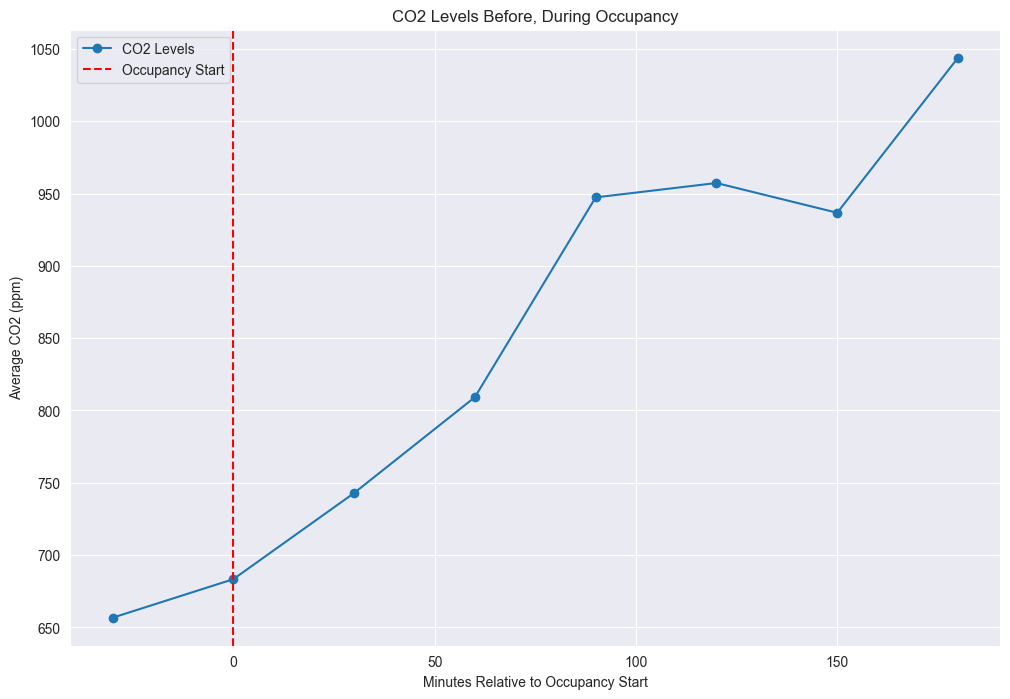

In [36]:
# Define time offsets (before, during occupancy)
time_window = [-30, 0, 30, 60, 90, 120, 150, 180]

# Copy the DataFrame
copy = uci_shifted_copy.copy()

# Compute CO2 baseline level when room is not occupied
baseline_co2_levels = copy[copy["Occupancy"] == 0]['CO2'].mean()

co2_trends = []

# Set time as index
copy.set_index("date", inplace=True)

for offset in time_window:
    # Shift CO₂ values relative to occupancy start times
    copy["shifted_co2"] = copy["CO2"].shift(periods=-offset, freq="min")

    # Keep only rows where occupancy is starting
    filtered_shifted = copy[copy["occupancy_start"]]

    # Compute mean CO₂ for this offset
    avg_co2 = filtered_shifted["shifted_co2"].mean()
    co2_trends.append(avg_co2)

# Plot CO₂ levels over time for each room
plt.figure(figsize=(12, 8))
plt.plot(time_window, co2_trends, marker='o', linestyle='-', label=f"CO2 Levels")

# Add occupancy start marker
plt.axvline(x=0, color="red", linestyle="--", label="Occupancy Start")

# Labels and title
plt.xlabel("Minutes Relative to Occupancy Start")
plt.ylabel("Average CO2 (ppm)")
plt.title("CO2 Levels Before, During Occupancy")
plt.legend()
plt.show()

#### Check CO2 levels during and after occupancy

In contrast to the above diagram, CO2 levels when occupancy ends seem to fluctuate

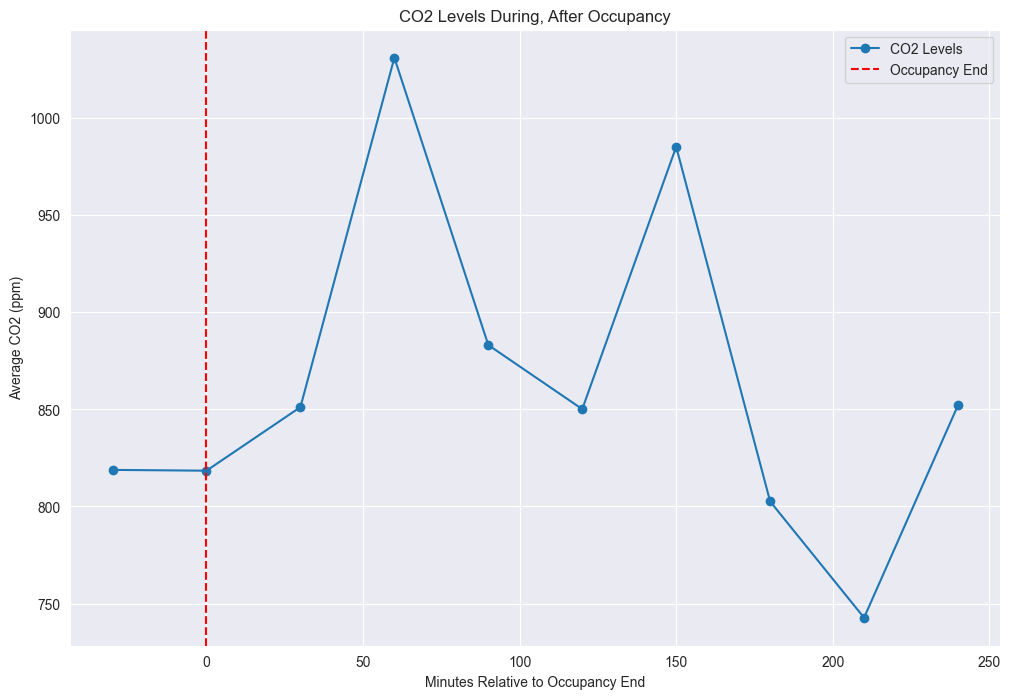

In [37]:
# Define time offsets (before, during occupancy)
time_window = [-30, 0, 30, 60, 90, 120, 150, 180, 210, 240]

# Copy the DataFrame
copy = uci_shifted_copy.copy()

co2_trends = []

# Set time as index
copy.set_index("date", inplace=True)

for offset in time_window:
    # Shift CO₂ values relative to occupancy start times
    copy["shifted_co2"] = copy["CO2"].shift(periods=offset, freq="min")

    # Keep only rows where occupancy is starting
    filtered_shifted = copy[copy["occupancy_end"]]

    # Compute mean CO₂ for this offset
    avg_co2 = filtered_shifted["shifted_co2"].mean()
    co2_trends.append(avg_co2)

# Plot CO₂ levels over time for each room
plt.figure(figsize=(12, 8))
plt.plot(time_window, co2_trends, marker='o', linestyle='-', label=f"CO2 Levels")

# Add occupancy start marker
plt.axvline(x=0, color="red", linestyle="--", label="Occupancy End")

# Labels and title
plt.xlabel("Minutes Relative to Occupancy End")
plt.ylabel("Average CO2 (ppm)")
plt.title("CO2 Levels During, After Occupancy")
plt.legend()
plt.show()

Looking at the below table, it seems that CO2 levels can be quite high at points of non-occupancy, which could explain the fluctuating values given above. This could indicate that the room has poor ventilation. The irregular decay pattern could also indicate external CO2 sources

In [38]:
df_filtered = copy[copy["Occupancy"] == 0]
df_selected = df_filtered[["CO2", "Occupancy", "occupancy_end"]]
df_sorted = df_selected.sort_values(by="CO2", ascending=False)
df_sorted

,CO2,Occupancy,occupancy_end
date,,,
2015-02-09 18:04:59,1784.50,0,True
2015-02-09 18:06:00,1774.00,0,False
2015-02-09 18:07:00,1755.50,0,False
2015-02-09 18:08:59,1742.00,0,False
2015-02-09 18:08:00,1742.00,0,False
...,...,...,...
2015-02-08 14:03:00,415.00,0,False
2015-02-08 16:51:00,414.50,0,False
2015-02-08 14:00:59,414.00,0,False
